# Gold Price Prediction — Modeling Challenges in Non-Stationary Financial Time Series

## Abstract

This project investigates various machine-learning approaches for gold price prediction. It focuses on understanding how different validation strategies influence model reliability. The notebook combines feature engineering (lags, rolling means) with both linear and ensemble regressors.  
Initial time-series experiments revealed the fundamental challenge of financial forecasting — excellent fit on historical data but catastrophic failure on forward predictions.

#### 1. Load libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import linregress
import yfinance as yf
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import time, logging, os, warnings, joblib, pydot
from DataScrapper import DataScrapper
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier


#### 2. Collect important data

##### Yahoo Finance Tickers Overview

| Key | Yahoo Ticker | Description | Category |
|-----|---------------|--------------|-----------|
| **Gold** | `GC=F` | Futures contract for **Gold** traded on COMEX (CME Group). Quoted in **USD per troy ounce**. Often used as a hedge against inflation and market uncertainty. | Commodity |
| **Silver** | `SI=F` | Futures contract for **Silver** traded on COMEX (CME Group). Quoted in **USD per troy ounce**. Used both industrially and as an investment metal. | Commodity |
| **Oil** | `CL=F` | Futures contract for **Crude Oil (WTI)** traded on NYMEX (CME Group). Quoted in **USD per barrel**. Key benchmark for global energy prices. | Commodity |
| **SP500** | `^GSPC` | The **S&P 500 Index**, tracking 500 of the largest publicly traded companies in the United States. Benchmark for the U.S. equity market. | Stock Index |
| **MSCI_Europe** | `IEUR` | **iShares MSCI Europe ETF**, providing exposure to large and mid-cap companies across 15 developed European markets. Issuer: BlackRock. | ETF / Stock Index |
| **Euro_STOXX_50** | `^STOXX50E` | The **Euro Stoxx 50 Index**, representing 50 leading companies from the Eurozone. Common benchmark for European equities. | Stock Index |
| **DAX** | `^GDAXI` | The **DAX Index**, consisting of 40 major German blue-chip companies traded on the Frankfurt Stock Exchange (Deutsche Börse). | Stock Index |
| **USDPLN** | `PLN=X` | **USD/PLN exchange rate**, showing how many Polish zloty (PLN) equal one U.S. dollar (USD). | Forex / Currency |
| **EURUSD** | `EURUSD=X` | **EUR/USD exchange rate**, the world’s most traded currency pair, showing how many U.S. dollars equal one euro. | Forex / Currency |
| **USDGBP** | `GBPUSD=X` | **GBP/USD exchange rate**, also known as “Cable.” Shows how many U.S. dollars equal one British pound sterling. | Forex / Currency |


In [2]:
tickers = {
    'Gold' : 'GC=F',
    'Silver' : 'SI=F',
    'Oil' : 'CL=F',
    'SP500' : '^GSPC',
    'MSCI_Europe' : 'IEUR',
    'Euro_STOXX_50' : '^STOXX50E',
    'DAX' : '^GDAXI',
    'USDPLN' : 'PLN=X',
    'EURUSD' : 'EURUSD=X',
    'USDGBP' : 'GBPUSD=X'    
}

Fetching data from [YahooFinance](https://finance.yahoo.com/?guccounter=1) with provided library.

In [4]:
data_fetcher = DataScrapper(tickers)

I found up that oldest data are from 2010, so i decided to pick start date as 2010.

In [5]:
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

In [6]:
data_fetcher.download(start_date, end_date)

2025-10-30 16:36:50,451 - Starting bulk data download...
[*********************100%***********************]  10 of 10 completed
2025-10-30 16:36:51,620 - Bulk download completed. Processing data...
2025-10-30 16:36:51,679 - Data saved to data/financial_data_2010-01-01_2025-10-30.csv
2025-10-30 16:36:51,679 - Dataset shape: (4127, 10)
2025-10-30 16:36:51,680 - Columns: ['Gold', 'Silver', 'Oil', 'SP500', 'MSCI_Europe', 'Euro_STOXX_50', 'DAX', 'USDPLN', 'EURUSD', 'USDGBP']
2025-10-30 16:36:51,680 - Date range: 2010-01-01 00:00:00 to 2025-10-29 00:00:00
2025-10-30 16:36:51,680 - Columns included:
2025-10-30 16:36:51,680 - - Gold
2025-10-30 16:36:51,680 - - Silver
2025-10-30 16:36:51,681 - - Oil
2025-10-30 16:36:51,681 - - SP500
2025-10-30 16:36:51,681 - - MSCI_Europe
2025-10-30 16:36:51,681 - - Euro_STOXX_50
2025-10-30 16:36:51,681 - - DAX
2025-10-30 16:36:51,681 - - USDPLN
2025-10-30 16:36:51,682 - - EURUSD
2025-10-30 16:36:51,682 - - USDGBP


#### 3. Load data to frame

Loading collected data from a CSV file

In [88]:
df = pd.read_csv('financial_data_2010-01-01_2025-10-03.csv', index_col=0, parse_dates=True)

#### 4. Data maintance

Preparing data:
- removing columns that have lot of NaN values,
- removing rows populated with NaN values.

In [89]:
df.head(10)

Gold     Silver        Oil        SP500  MSCI_Europe  \
Date                                                                      
2010-01-01          NaN        NaN        NaN          NaN          NaN   
2010-01-04  1117.699951  17.440001  81.510002  1132.989990          NaN   
2010-01-05  1118.099976  17.781000  81.769997  1136.520020          NaN   
2010-01-06  1135.900024  18.163000  83.180000  1137.140015          NaN   
2010-01-07  1133.099976  18.333000  82.660004  1141.689941          NaN   
2010-01-08  1138.199951  18.458000  82.750000  1144.979980          NaN   
2010-01-11  1150.699951  18.683001  82.519997  1146.979980          NaN   
2010-01-12  1128.900024  18.243000  80.790001  1136.219971          NaN   
2010-01-13  1136.400024  18.538000  79.650002  1145.680054          NaN   
2010-01-14  1142.599976  18.643000  79.389999  1148.459961          NaN   

            Euro_STOXX_50          DAX  USDPLN    EURUSD    USDGBP  
Date                                                                
2010-01-01            NaN          NaN  2.8415  1.438994  1.613294  
2010-01-04    3017.800049  6048.299805  2.8250  1.442398  1.611370  
2010-01-05    3012.360107  6031.859863  2.8453  1.436596  1.599079  
2010-01-06    3009.659912  6034.330078  2.8379  1.440403  1.602384  
2010-01-07    3007.340088  6019.359863  2.8673  1.431803  1.593397  
2010-01-08    3017.850098  6037.609863  2.8182  1.441109  1.602410  
2010-01-11    3010.239990  6040.500000  2.7980  1.451126  1.611292  
2010-01-12    2976.889893  5943.000000  2.8122  1.447660  1.615170  
2010-01-13    2978.409912  5963.140137  2.7868  1.452391  1.628611  
2010-01-14    2989.709961  5988.879883  2.7904  1.449990  1.633400

Checking data formats, and population of data in columns.

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4109 entries, 2010-01-01 to 2025-10-03
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gold           4108 non-null   float64
 1   Silver         4108 non-null   float64
 2   Oil            4108 non-null   float64
 3   SP500          4108 non-null   float64
 4   MSCI_Europe    2950 non-null   float64
 5   Euro_STOXX_50  4108 non-null   float64
 6   DAX            4108 non-null   float64
 7   USDPLN         4109 non-null   float64
 8   EURUSD         4109 non-null   float64
 9   USDGBP         4109 non-null   float64
dtypes: float64(10)
memory usage: 353.1 KB


Sum of all NaN's in each column.

In [91]:
df.isna().sum()

Gold                1
Silver              1
Oil                 1
SP500               1
MSCI_Europe      1159
Euro_STOXX_50       1
DAX                 1
USDPLN              0
EURUSD              0
USDGBP              0
dtype: int64

We have big part of data missing from MSCI Europe so we will drop this column

In [92]:
df = df.drop(columns=['MSCI_Europe'])

Removing row if there's any NaN value.

In [94]:
df = df.dropna(how='any')

#### Data analysis

In [ ]:
df.describe() # yield basic statistics from the data

Gold       Silver          Oil        SP500  Euro_STOXX_50  \
count  4108.000000  4108.000000  4108.000000  4108.000000    4108.000000   
mean   1624.646616    22.654563    71.729679  2886.807826    3472.712552   
std     498.670894     6.857104    20.889246  1424.259399     767.221927   
min    1050.800049    11.735000   -37.630001  1022.580017    1995.010010   
25%    1266.674957    16.984001    53.947500  1792.732544    2945.044922   
50%    1497.500000    21.035000    71.919998  2550.164917    3365.275024   
75%    1816.524994    27.314250    88.524998  3991.362488    3830.937500   
max    3867.500000    48.584000   123.699997  6715.350098    5645.810059   

                DAX       USDPLN       EURUSD       USDGBP  
count   4108.000000  4108.000000  4108.000000  4108.000000  
mean   11953.769660     3.663334     1.186765     1.405616  
std     4226.578642     0.453165     0.112809     0.149376  
min     5072.330078     2.643400     0.959619     1.072754  
25%     9020.977539     3.264270     1.097318     1.277931  
50%    11867.850098     3.756990     1.152034     1.355004  
75%    14176.967773     3.959795     1.287126     1.554805  
max    24549.560547     5.001400     1.484406     1.716090

Checking if data starts at 2010 and ends at 2025

Display first 10 rwos.

In [96]:
display(df.head(10))

Gold     Silver        Oil        SP500  Euro_STOXX_50  \
Date                                                                        
2010-01-04  1117.699951  17.440001  81.510002  1132.989990    3017.800049   
2010-01-05  1118.099976  17.781000  81.769997  1136.520020    3012.360107   
2010-01-06  1135.900024  18.163000  83.180000  1137.140015    3009.659912   
2010-01-07  1133.099976  18.333000  82.660004  1141.689941    3007.340088   
2010-01-08  1138.199951  18.458000  82.750000  1144.979980    3017.850098   
2010-01-11  1150.699951  18.683001  82.519997  1146.979980    3010.239990   
2010-01-12  1128.900024  18.243000  80.790001  1136.219971    2976.889893   
2010-01-13  1136.400024  18.538000  79.650002  1145.680054    2978.409912   
2010-01-14  1142.599976  18.643000  79.389999  1148.459961    2989.709961   
2010-01-15  1130.099976  18.410999  78.000000  1136.030029    2940.250000   

                    DAX  USDPLN    EURUSD    USDGBP  
Date                                                 
2010-01-04  6048.299805  2.8250  1.442398  1.611370  
2010-01-05  6031.859863  2.8453  1.436596  1.599079  
2010-01-06  6034.330078  2.8379  1.440403  1.602384  
2010-01-07  6019.359863  2.8673  1.431803  1.593397  
2010-01-08  6037.609863  2.8182  1.441109  1.602410  
2010-01-11  6040.500000  2.7980  1.451126  1.611292  
2010-01-12  5943.000000  2.8122  1.447660  1.615170  
2010-01-13  5963.140137  2.7868  1.452391  1.628611  
2010-01-14  5988.879883  2.7904  1.449990  1.633400  
2010-01-15  5875.970215  2.8154  1.439097  1.626995

Display last 10 rows.

In [97]:
df.tail(10)

Gold     Silver        Oil        SP500  Euro_STOXX_50  \
Date                                                                        
2025-09-22  3740.699951  43.799000  62.639999  6693.750000    5442.049805   
2025-09-23  3780.600098  44.192001  63.410000  6656.919922    5472.390137   
2025-09-24  3732.100098  43.777000  64.989998  6637.970215    5464.560059   
2025-09-25  3736.899902  44.696999  64.980003  6604.720215    5444.890137   
2025-09-26  3775.300049  46.221001  65.720001  6643.700195    5499.700195   
2025-09-29  3820.899902  46.612000  63.450001  6661.209961    5506.850098   
2025-09-30  3840.800049  46.252998  62.369999  6688.459961    5529.959961   
2025-10-01  3867.500000  47.290001  61.779999  6711.200195    5581.209961   
2025-10-02  3839.699951  46.000000  60.480000  6715.350098    5645.810059   
2025-10-03  3839.699951  46.000000  60.480000  6715.350098    5645.810059   

                     DAX    USDPLN    EURUSD    USDGBP  
Date                                                    
2025-09-22  23527.050781  3.631100  1.173695  1.346475  
2025-09-23  23611.330078  3.605420  1.180108  1.351497  
2025-09-24  23666.810547  3.603580  1.181447  1.352448  
2025-09-25  23534.830078  3.630047  1.174467  1.345240  
2025-09-26  23739.470703  3.660682  1.166276  1.333653  
2025-09-29  23745.060547  3.643120  1.170823  1.340824  
2025-09-30  23880.720703  3.635418  1.173144  1.343725  
2025-10-01  24113.619141  3.633136  1.173585  1.344339  
2025-10-02  24422.560547  3.628900  1.173406  1.348018  
2025-10-03  24422.560547  3.630367  1.172512  1.344664

Make sure that there's no NaN values.

In [98]:
df.isna().sum()

Gold             0
Silver           0
Oil              0
SP500            0
Euro_STOXX_50    0
DAX              0
USDPLN           0
EURUSD           0
USDGBP           0
dtype: int64

Set all data to represent prices in USD.

In [99]:
# Data is clean, now we have to calculate so erverythin will be in USD
df_unified = df.copy()
df_unified['Euro_STOXX_50'] = df_unified['Euro_STOXX_50'] * df_unified['EURUSD'] # Convert Euro STOXX 50 from EUR to USD
df_unified['DAX'] = df_unified['DAX'] * df_unified['EURUSD'] # Convert DAX from EUR to USD

In [100]:
df_unified.describe()

Gold       Silver          Oil        SP500  Euro_STOXX_50  \
count  4108.000000  4108.000000  4108.000000  4108.000000    4108.000000   
mean   1624.646616    22.654563    71.729679  2886.807826    4070.248031   
std     498.670894     6.857104    20.889246  1424.259399     730.026049   
min    1050.800049    11.735000   -37.630001  1022.580017    2557.374000   
25%    1266.674957    16.984001    53.947500  1792.732544    3568.190656   
50%    1497.500000    21.035000    71.919998  2550.164917    3970.394429   
75%    1816.524994    27.314250    88.524998  3991.362488    4399.095301   
max    3867.500000    48.584000   123.699997  6715.350098    6624.826752   

                DAX       USDPLN       EURUSD       USDGBP  
count   4108.000000  4108.000000  4108.000000  4108.000000  
mean   13877.427466     3.663334     1.186765     1.405616  
std     4279.075855     0.453165     0.112809     0.149376  
min     6883.474131     2.643400     0.959619     1.072754  
25%    10975.409432     3.264270     1.097318     1.277931  
50%    13145.610822     3.756990     1.152034     1.355004  
75%    16053.188939     3.959795     1.287126     1.554805  
max    28783.294833     5.001400     1.484406     1.716090

In [101]:
df_unified.head()

Gold     Silver        Oil        SP500  Euro_STOXX_50  \
Date                                                                        
2010-01-04  1117.699951  17.440001  81.510002  1132.989990    4352.868250   
2010-01-05  1118.099976  17.781000  81.769997  1136.520020    4327.544230   
2010-01-06  1135.900024  18.163000  83.180000  1137.140015    4335.124196   
2010-01-07  1133.099976  18.333000  82.660004  1141.689941    4305.919241   
2010-01-08  1138.199951  18.458000  82.750000  1144.979980    4349.051121   

                    DAX  USDPLN    EURUSD    USDGBP  
Date                                                 
2010-01-04  8724.054531  2.8250  1.442398  1.611370  
2010-01-05  8665.345250  2.8453  1.436596  1.599079  
2010-01-06  8691.869213  2.8379  1.440403  1.602384  
2010-01-07  8618.538874  2.8673  1.431803  1.593397  
2010-01-08  8700.854282  2.8182  1.441109  1.602410

Everything is in USD now, so we can save the final dataset

In [ ]:
df_unified.to_csv('data/financial_data_usd_2010-01-01_2025-10-03.csv', encoding='utf-8')

Load prepared dataset.

In [2]:
prepared_df = pd.read_csv('data/financial_data_usd_2010-01-01_2025-10-03.csv', index_col=0, parse_dates=True)

In [3]:
prepared_df

Gold     Silver        Oil        SP500  Euro_STOXX_50  \
Date                                                                        
2010-01-04  1117.699951  17.440001  81.510002  1132.989990    4352.868250   
2010-01-05  1118.099976  17.781000  81.769997  1136.520020    4327.544230   
2010-01-06  1135.900024  18.163000  83.180000  1137.140015    4335.124196   
2010-01-07  1133.099976  18.333000  82.660004  1141.689941    4305.919241   
2010-01-08  1138.199951  18.458000  82.750000  1144.979980    4349.051121   
...                 ...        ...        ...          ...            ...   
2025-09-29  3820.899902  46.612000  63.450001  6661.209961    6447.547287   
2025-09-30  3840.800049  46.252998  62.369999  6688.459961    6487.441231   
2025-10-01  3867.500000  47.290001  61.779999  6711.200195    6550.023946   
2025-10-02  3839.699951  46.000000  60.480000  6715.350098    6624.826752   
2025-10-03  3839.699951  46.000000  60.480000  6715.350098    6619.778332   

                     DAX    USDPLN    EURUSD    USDGBP  
Date                                                    
2010-01-04   8724.054531  2.825000  1.442398  1.611370  
2010-01-05   8665.345250  2.845300  1.436596  1.599079  
2010-01-06   8691.869213  2.837900  1.440403  1.602384  
2010-01-07   8618.538874  2.867300  1.431803  1.593397  
2010-01-08   8700.854282  2.818200  1.441109  1.602410  
...                  ...       ...       ...       ...  
2025-09-29  27801.265333  3.643120  1.170823  1.340824  
2025-09-30  28015.532340  3.635418  1.173144  1.343725  
2025-10-01  28299.380225  3.633136  1.173585  1.344339  
2025-10-02  28657.576289  3.628900  1.173406  1.348018  
2025-10-03  28635.737907  3.630367  1.172512  1.344664  

[4108 rows x 9 columns]

In [4]:
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4108 entries, 2010-01-04 to 2025-10-03
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gold           4108 non-null   float64
 1   Silver         4108 non-null   float64
 2   Oil            4108 non-null   float64
 3   SP500          4108 non-null   float64
 4   Euro_STOXX_50  4108 non-null   float64
 5   DAX            4108 non-null   float64
 6   USDPLN         4108 non-null   float64
 7   EURUSD         4108 non-null   float64
 8   USDGBP         4108 non-null   float64
dtypes: float64(9)
memory usage: 320.9 KB


Split dataset for train and test set. Decided to set everything before 2025 to
be train data.

Starting from 2025 data will be test data.

In [49]:
train_df = prepared_df[prepared_df.index.year < 2025]

In [50]:
test_df = prepared_df[prepared_df.index.year >= 2025]

Checking the correctness of data division.

In [7]:
test_df

Gold     Silver        Oil        SP500  Euro_STOXX_50  \
Date                                                                        
2025-01-02  2658.899902  29.622000  73.129997  5868.549805    5040.610518   
2025-01-03  2645.000000  29.806000  73.959999  5942.470215    5002.105122   
2025-01-06  2638.399902  30.341999  73.559998  5975.379883    5138.905918   
2025-01-07  2656.699951  30.447001  74.250000  5909.029785    5205.462912   
2025-01-08  2664.500000  30.452000  73.320000  5918.250000    5169.036020   
...                 ...        ...        ...          ...            ...   
2025-09-29  3820.899902  46.612000  63.450001  6661.209961    6447.547287   
2025-09-30  3840.800049  46.252998  62.369999  6688.459961    6487.441231   
2025-10-01  3867.500000  47.290001  61.779999  6711.200195    6550.023946   
2025-10-02  3839.699951  46.000000  60.480000  6715.350098    6624.826752   
2025-10-03  3839.699951  46.000000  60.480000  6715.350098    6619.778332   

                     DAX    USDPLN    EURUSD    USDGBP  
Date                                                    
2025-01-02  20729.248896  4.128580  1.035186  1.251925  
2025-01-03  20439.971904  4.159400  1.026821  1.238022  
2025-01-06  20833.485628  4.141060  1.030535  1.242684  
2025-01-07  21126.474632  4.091800  1.038637  1.251095  
2025-01-08  21032.422699  4.116860  1.034554  1.247785  
...                  ...       ...       ...       ...  
2025-09-29  27801.265333  3.643120  1.170823  1.340824  
2025-09-30  28015.532340  3.635418  1.173144  1.343725  
2025-10-01  28299.380225  3.633136  1.173585  1.344339  
2025-10-02  28657.576289  3.628900  1.173406  1.348018  
2025-10-03  28635.737907  3.630367  1.172512  1.344664  

[196 rows x 9 columns]

In [8]:
train_df

Gold     Silver        Oil        SP500  Euro_STOXX_50  \
Date                                                                        
2010-01-04  1117.699951  17.440001  81.510002  1132.989990    4352.868250   
2010-01-05  1118.099976  17.781000  81.769997  1136.520020    4327.544230   
2010-01-06  1135.900024  18.163000  83.180000  1137.140015    4335.124196   
2010-01-07  1133.099976  18.333000  82.660004  1141.689941    4305.919241   
2010-01-08  1138.199951  18.458000  82.750000  1144.979980    4349.051121   
...                 ...        ...        ...          ...            ...   
2024-12-25  2620.000000  29.974001  70.099998  6040.040039    5048.299103   
2024-12-26  2638.800049  30.047001  69.620003  6037.589844    5046.829676   
2024-12-27  2617.199951  29.655001  70.599998  5970.839844    5106.191199   
2024-12-30  2606.100098  29.106001  70.989998  5906.939941    5078.355730   
2024-12-31  2629.199951  28.940001  71.720001  5881.629883    5067.046562   

                     DAX    USDPLN    EURUSD    USDGBP  
Date                                                    
2010-01-04   8724.054531  2.825000  1.442398  1.611370  
2010-01-05   8665.345250  2.845300  1.436596  1.599079  
2010-01-06   8691.869213  2.837900  1.440403  1.602384  
2010-01-07   8618.538874  2.867300  1.431803  1.593397  
2010-01-08   8700.854282  2.818200  1.441109  1.602410  
...                  ...       ...       ...       ...  
2024-12-25  20647.839921  4.087380  1.040258  1.253604  
2024-12-26  20641.829880  4.088420  1.039955  1.254375  
2024-12-27  20830.018892  4.088500  1.042318  1.252976  
2024-12-30  20763.994439  4.092367  1.042938  1.257881  
2024-12-31  20717.754373  4.107070  1.040615  1.254910  

[3912 rows x 9 columns]

Creating X, Y for train and test sets.

In [51]:
X_train = train_df.drop(columns=['Gold'])
y_train = train_df['Gold']

In [52]:
X_test = test_df.drop(columns=['Gold'])
y_test = test_df['Gold']

Checking shape of X & Y sets from train and test sets, and making sure that X & Y are properly assingned.

In [11]:
X_train.shape

(3912, 8)

In [31]:
X_train.tail()

Silver        Oil        SP500  Euro_STOXX_50           DAX  \
Date                                                                         
2024-12-25  29.974001  70.099998  6040.040039    5048.299103  20647.839921   
2024-12-26  30.047001  69.620003  6037.589844    5046.829676  20641.829880   
2024-12-27  29.655001  70.599998  5970.839844    5106.191199  20830.018892   
2024-12-30  29.106001  70.989998  5906.939941    5078.355730  20763.994439   
2024-12-31  28.940001  71.720001  5881.629883    5067.046562  20717.754373   

              USDPLN    EURUSD    USDGBP  
Date                                      
2024-12-25  4.087380  1.040258  1.253604  
2024-12-26  4.088420  1.039955  1.254375  
2024-12-27  4.088500  1.042318  1.252976  
2024-12-30  4.092367  1.042938  1.257881  
2024-12-31  4.107070  1.040615  1.254910

In [32]:
X_test.head()

Silver        Oil        SP500  Euro_STOXX_50           DAX  \
Date                                                                         
2025-01-02  29.622000  73.129997  5868.549805    5040.610518  20729.248896   
2025-01-03  29.806000  73.959999  5942.470215    5002.105122  20439.971904   
2025-01-06  30.341999  73.559998  5975.379883    5138.905918  20833.485628   
2025-01-07  30.447001  74.250000  5909.029785    5205.462912  21126.474632   
2025-01-08  30.452000  73.320000  5918.250000    5169.036020  21032.422699   

             USDPLN    EURUSD    USDGBP  
Date                                     
2025-01-02  4.12858  1.035186  1.251925  
2025-01-03  4.15940  1.026821  1.238022  
2025-01-06  4.14106  1.030535  1.242684  
2025-01-07  4.09180  1.038637  1.251095  
2025-01-08  4.11686  1.034554  1.247785

Checking timeseries:
- simple format %Y-%m-%d,
- range.

In [33]:
X_train.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23',
               '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=3912, freq=None)

In [34]:
y_train.shape

(3912,)

Visualization of the gold price time series over the training set time horizon.

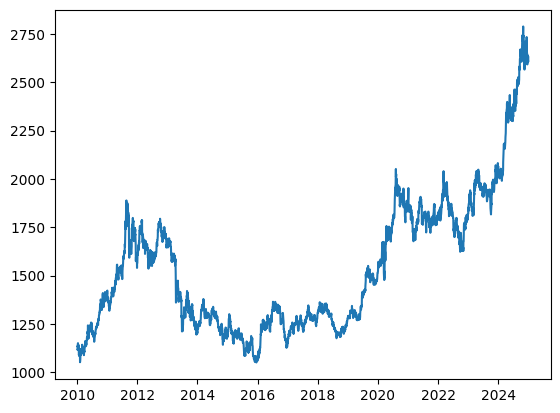

In [35]:
plt.plot(X_train.index, y_train)

Residual plot.

(array([ 657., 1222.,  331.,  551.,  633.,  301.,   22.,   91.,   41.,
          63.]),
 array([1050.80004883, 1224.57004395, 1398.34003906, 1572.11003418,
        1745.8800293 , 1919.65002441, 2093.42001953, 2267.19001465,
        2440.96000977, 2614.73000488, 2788.5       ]),
 <BarContainer object of 10 artists>)

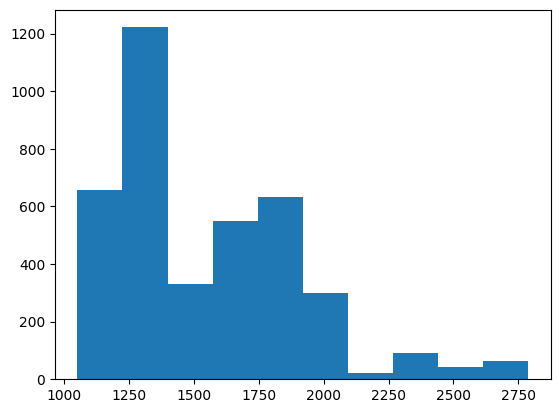

In [36]:
plt.hist(y_train)

Gold does not have a normal decomposition.

#### Data seasonality

Visualization of the seasonality of the gold price on individual days of the week.

2025-10-30 16:37:51,610 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 16:37:51,616 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'daily gold val change')

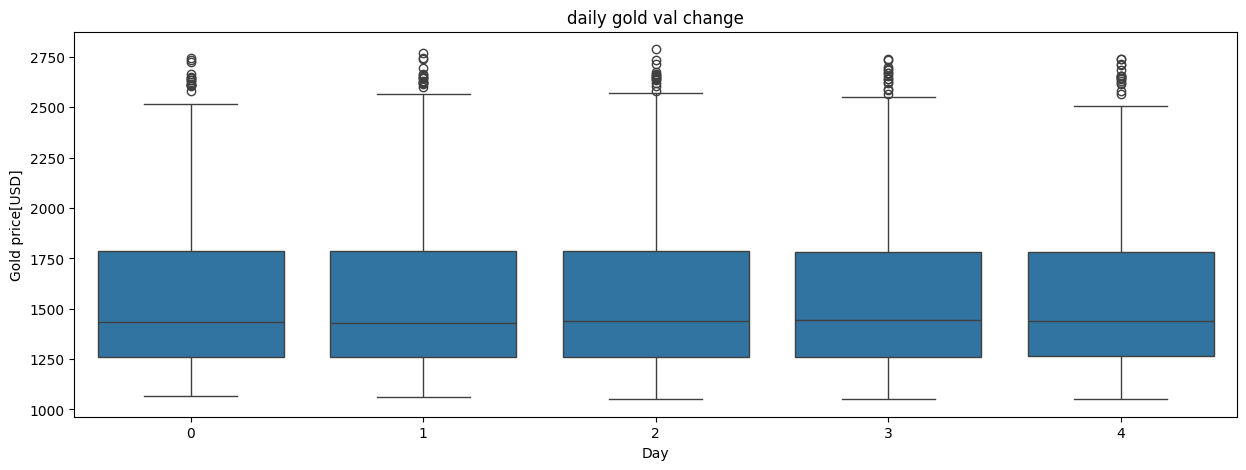

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=X_train.index.day_of_week, y=y_train, data=X_train)
ax.set_xlabel("Day")
ax.set_ylabel("Gold price[USD]")
ax.set_title("daily gold val change")

The analysis shows a lack of daily seasonality.

Visualization of the seasonality of the gold price in individual months.

2025-10-30 16:37:53,546 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 16:37:53,552 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Monthly gold val change')

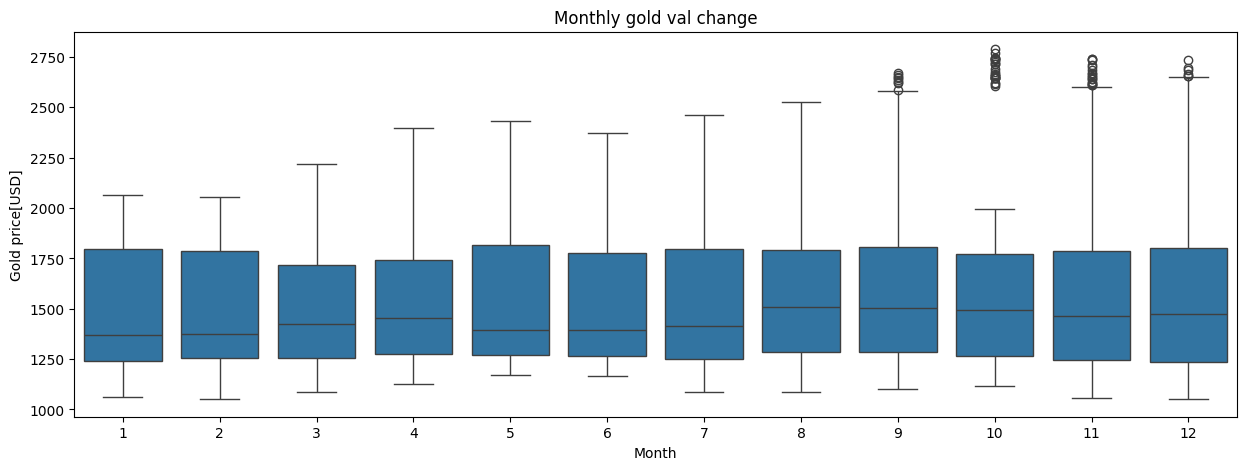

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=X_train.index.month, y=y_train, data=X_train)
ax.set_xlabel("Month")
ax.set_ylabel("Gold price[USD]")
ax.set_title("Monthly gold val change")

No monthly seasonality.

Visualization of the seasonality of the gold price in individual years.

2025-10-30 16:37:55,232 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-30 16:37:55,238 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Year gold val change')

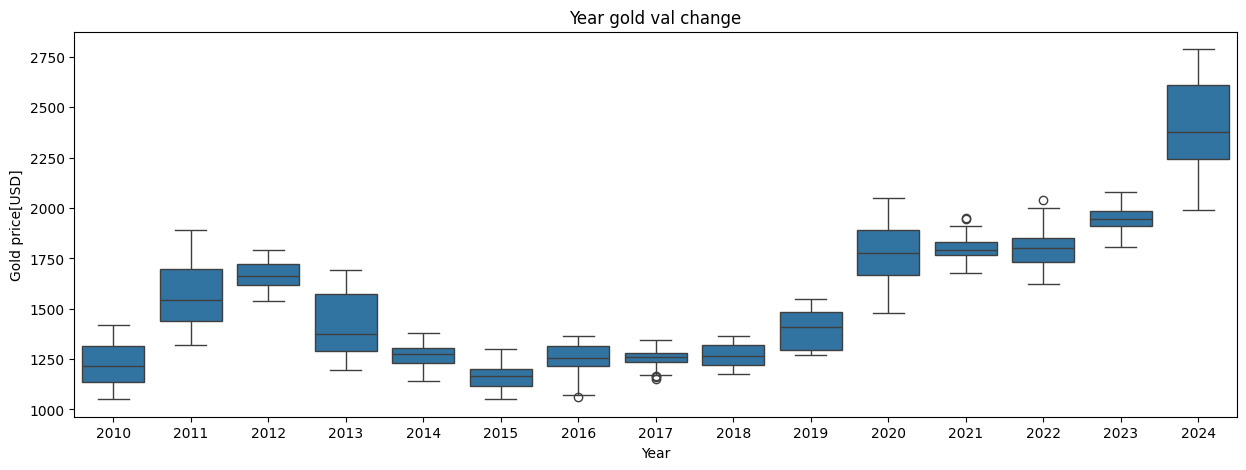

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=X_train.index.year, y=y_train, data=X_train)
ax.set_xlabel("Year")
ax.set_ylabel("Gold price[USD]")
ax.set_title("Year gold val change")

The analysis showed seasonality in individual years. In 2010-2012, there was a price increase, from 2012-2015 a decrease, then price stabilization from 2016-2018, and an increase from 2019-2024, although prices stabilized in the 2020-2022 period.

#### Data correlation

Visualization of data correlations between variables.

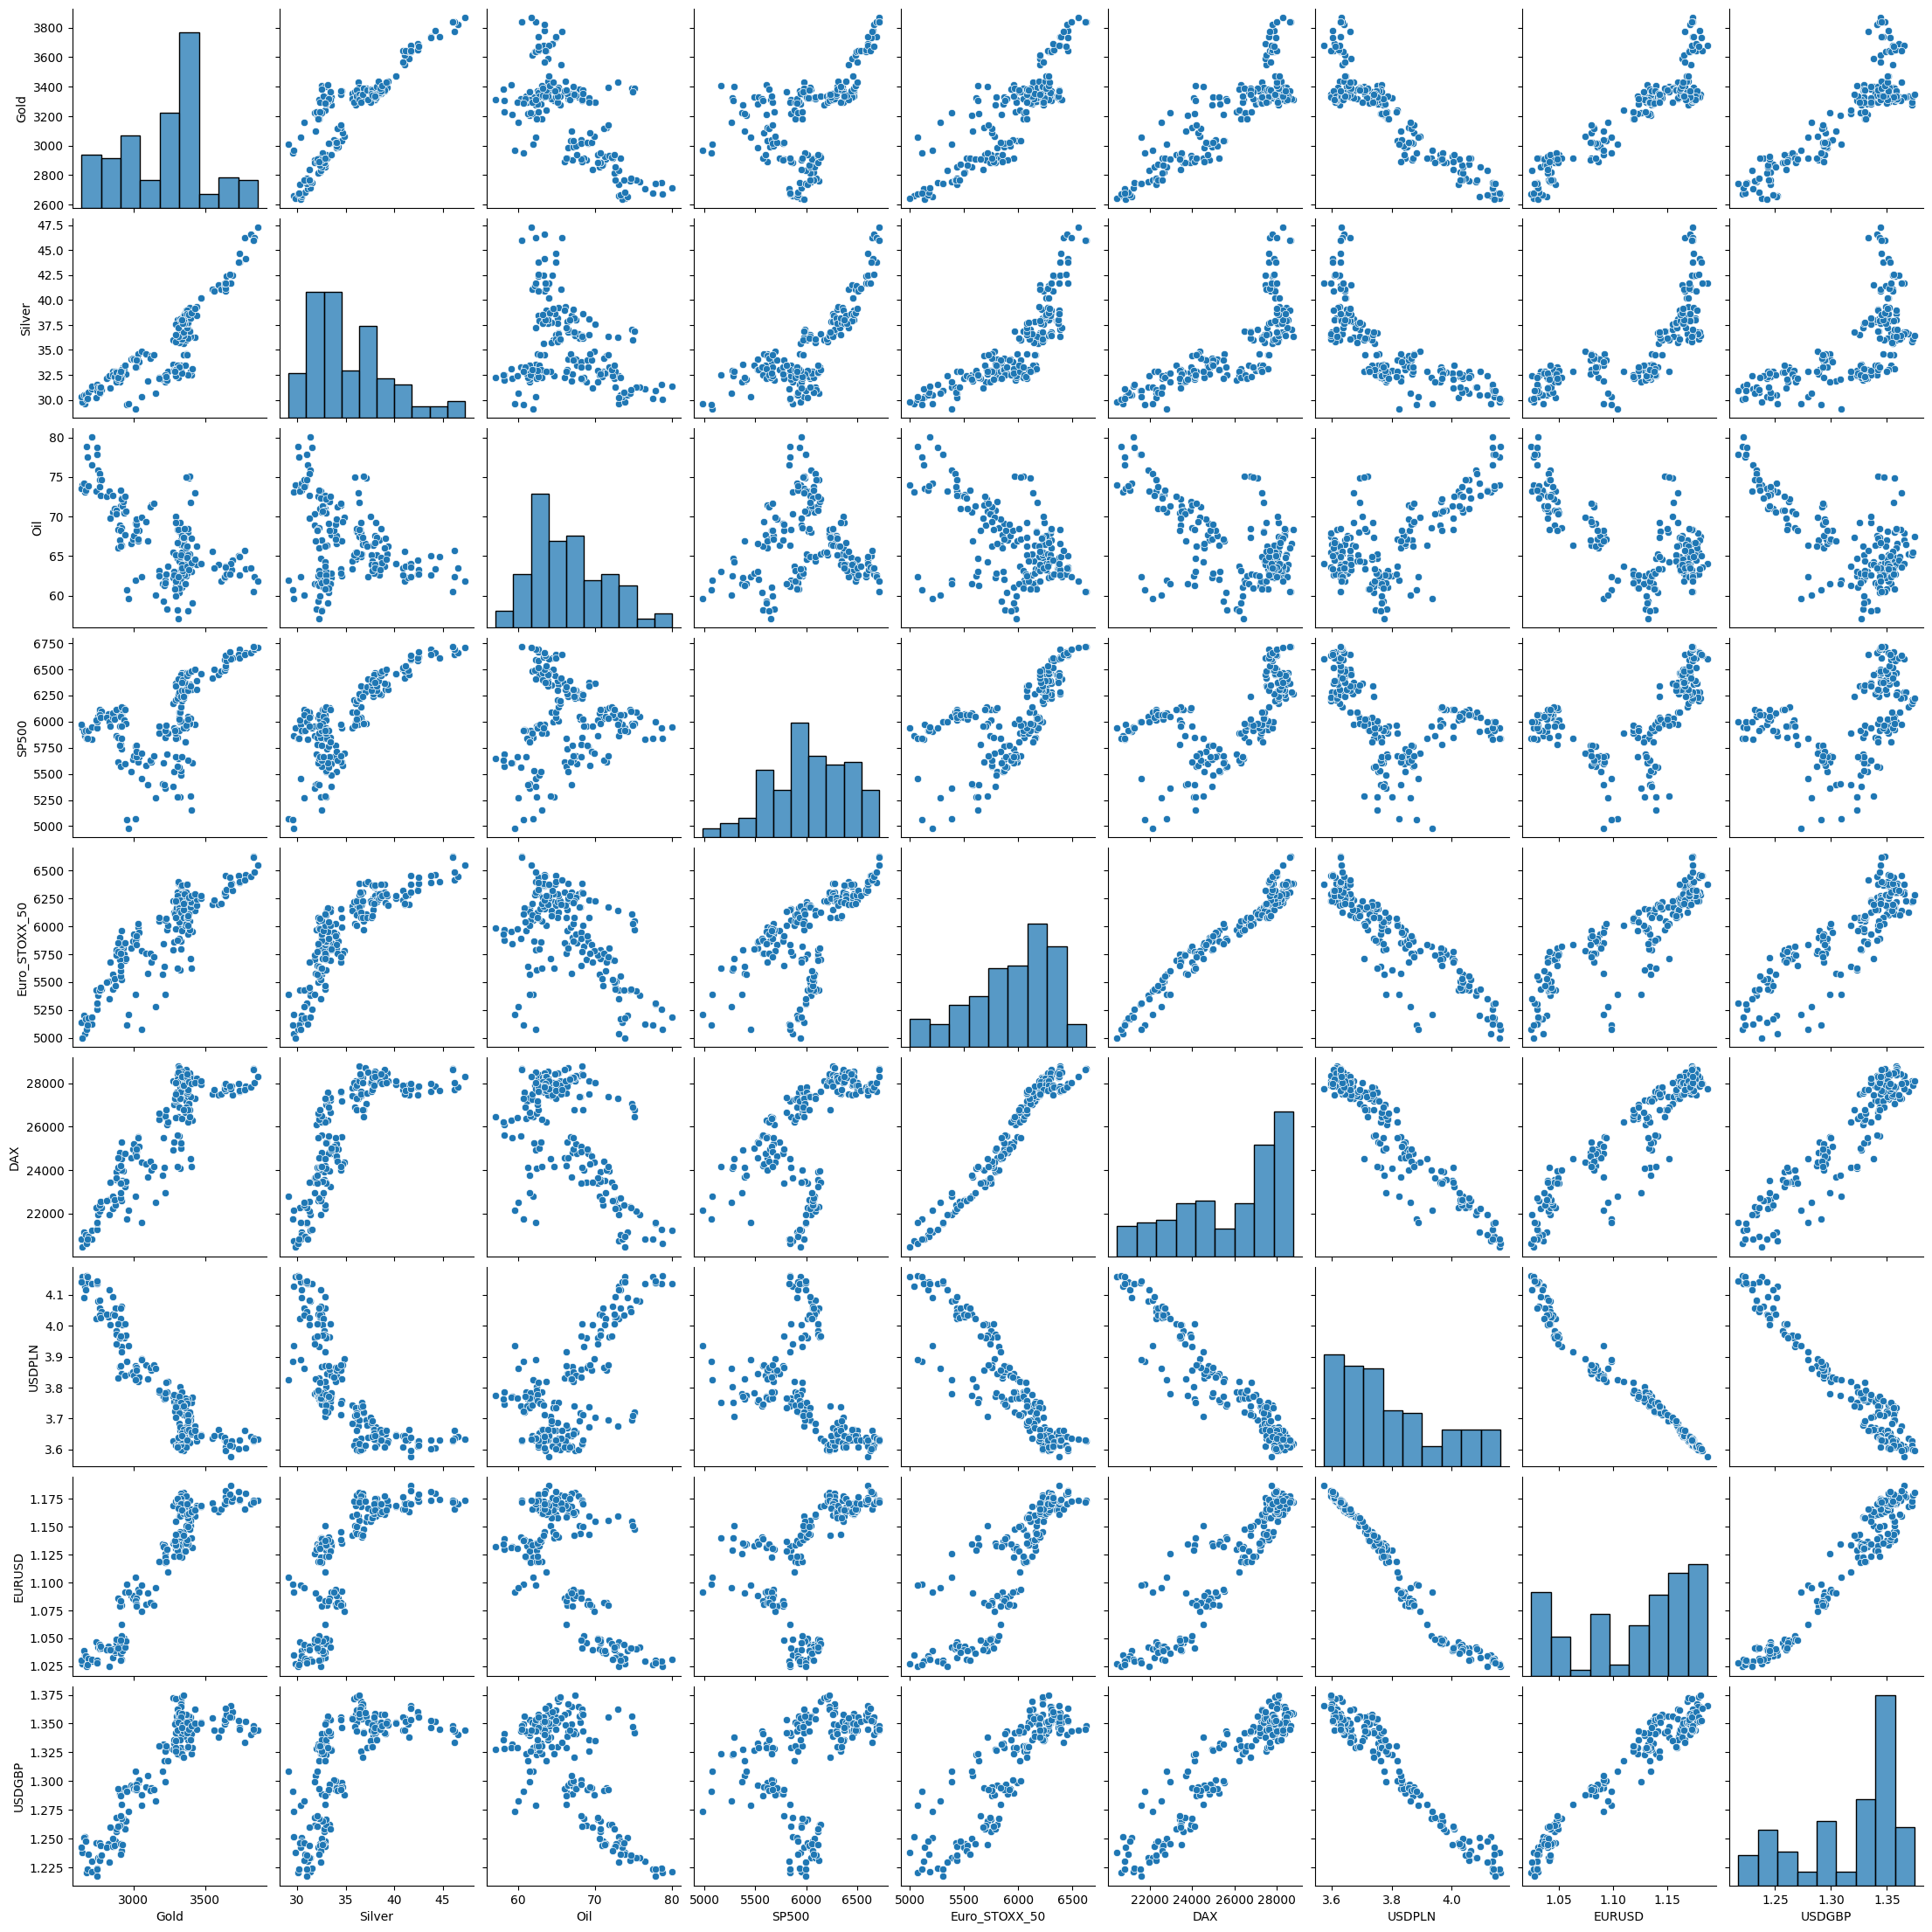

In [40]:
sns.pairplot(test_df)

Dependence of the correlation of variables on the gold price.

In [41]:
corr_matrix = test_df.corr()['Gold'].round(2)

In [42]:
corr_matrix

Gold             1.00
Silver           0.86
Oil             -0.66
SP500            0.52
Euro_STOXX_50    0.86
DAX              0.86
USDPLN          -0.91
EURUSD           0.92
USDGBP           0.88
Name: Gold, dtype: float64

Visualization of correlations of all variables.

In [43]:
corr_matrix_df = test_df.corr().round(2)

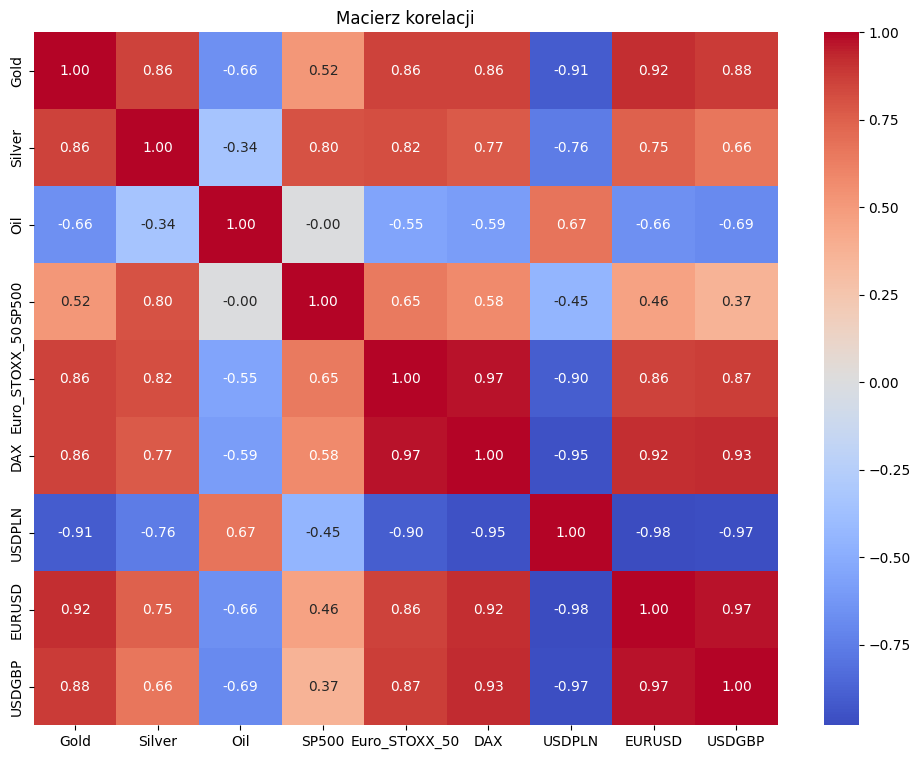

In [44]:
plt.figure(figsize=(12,9))
sns.heatmap(corr_matrix_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

Statistical examination of the X variables for significance and impact on the gold price. Variables with a P index above 0.05 are removed from the model.

In [ ]:
# fit a multiple regression model
X_train_with_const = sm.add_constant(X_train, prepend=True, has_constant='skip')
X_test_with_const =  sm.add_constant(X_test, prepend=True, has_constant='skip')

model_full = sm.OLS(endog=y_train, exog=X_train_with_const)
fitted_model_full = model_full.fit()
fitted_model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     7000.
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:38:11   Log-Likelihood:                -23138.
No. Observations:                3912   AIC:                         4.629e+04
Df Residuals:                    3903   BIC:                         4.635e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2132.6175    109.800     19.423      0.000    1917.348    2347.887
Silver           28.7216      0.339     84.733      0.000      28.057      29.386
Oil              -0.5771      0.105     -5.506      0.000      -0.783      -0.372
SP500             0.4032      0.006     70.312      0.000       0.392       0.414
Euro_STOXX_50    -0.1546      0.008    -19.633      0.000      -0.170      -0.139
DAX              -0.0348      0.002    -18.046      0.000      -0.039      -0.031
USDPLN         -258.4874     13.837    -18.682      0.000    -285.615    -231.360
EURUSD         -315.0256     50.580     -6.228      0.000    -414.192    -215.859
USDGBP           84.1058     21.472      3.917      0.000      42.008     126.203
==============================================================================
Omnibus:                       44.538   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.076
Skew:                          -0.073   Prob(JB):                     2.23e-16
Kurtosis:                       3.649   Cond. No.                     1.21e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### ML models with validation.

##### Ridge model with hyperparameter tuning.

In [61]:
pipeline = Pipeline([
    ('prep', PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("model", RidgeCV())
])

parm_grid = {
    'prep__degree' : (1,3),
    'prep__interaction_only' : [True, False],
    'prep__include_bias' : [True, False],
    'prep__order' : ['C', 'F'],
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'model__fit_intercept': [True, False],
    'model__scoring':['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error' ]
}

grid = GridSearchCV(pipeline, parm_grid, cv=5, n_jobs=4)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('model', RidgeCV())]),
             n_jobs=4,
             param_grid={'model__fit_intercept': [True, False],
                         'model__scoring': ['r2', 'neg_mean_absolute_error',
                                            'neg_mean_squared_error'],
                         'prep__degree': (1, 3),
                         'prep__include_bias': [True, False],
                         'prep__interaction_only': [True, False],
                         'prep__order': ['C', 'F'],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]})

The best model parameters.

In [47]:
grid.best_params_

{'model__fit_intercept': False,
 'model__scoring': 'neg_mean_absolute_error',
 'prep__degree': 1,
 'prep__include_bias': False,
 'prep__interaction_only': True,
 'prep__order': 'C',
 'scaler__with_mean': False,
 'scaler__with_std': True}

$R^2$ score of the best model

In [48]:
grid.score(X_train,y_train)

0.928223175642445

Average $R^2$ score for cross-validation of the best model

In [49]:
grid.best_score_

np.float64(0.05571096642664961)

In [62]:
y_pred_ridge = grid.predict(X_test)

In [55]:
def plot_predictions(preds, model:str):
    plt.figure(figsize=(12,5))
    plt.plot(range(len(y_test)), y_test, label='Actual', linewidth=2)
    plt.plot(range(len(y_test)), preds, label='Prediction', linewidth=2)
    plt.title(f'Actual vs Predicted Gold_next — model: {model}')
    plt.xlabel('Test sample index')
    plt.ylabel('Gold next-day price')
    plt.legend()
    plt.tight_layout()
    plt.show()

Visualization of gold prices and model predictions.

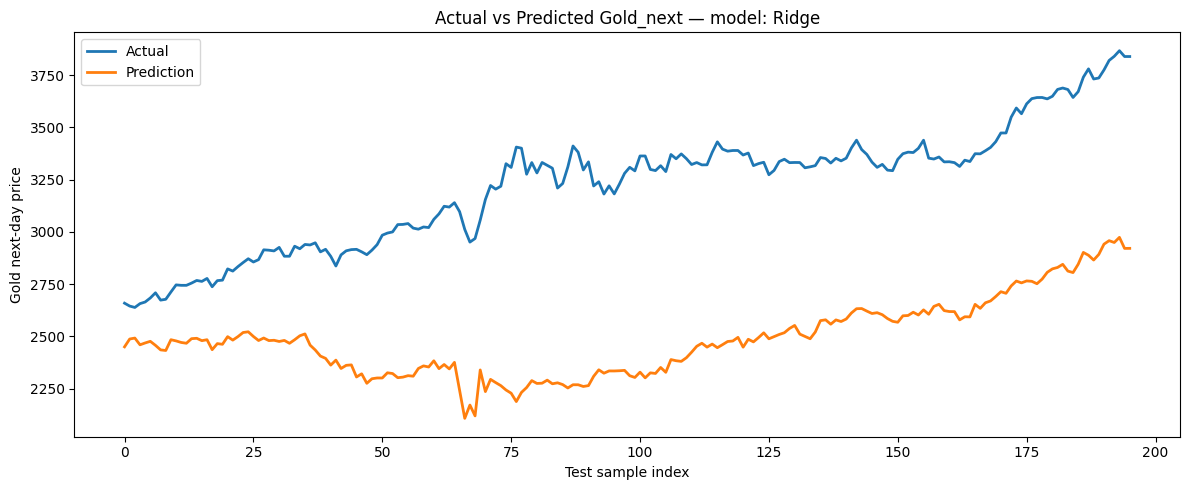

In [63]:
plot_predictions(y_pred_ridge, 'Ridge')

Residual plot.

(array([10., 16., 11.,  8., 11., 46., 48., 29., 13.,  4.]),
 array([ 146.59556284,  253.76787335,  360.94018385,  468.11249436,
         575.28480487,  682.45711538,  789.62942589,  896.8017364 ,
        1003.97404691, 1111.14635742, 1218.31866793]),
 <BarContainer object of 10 artists>)

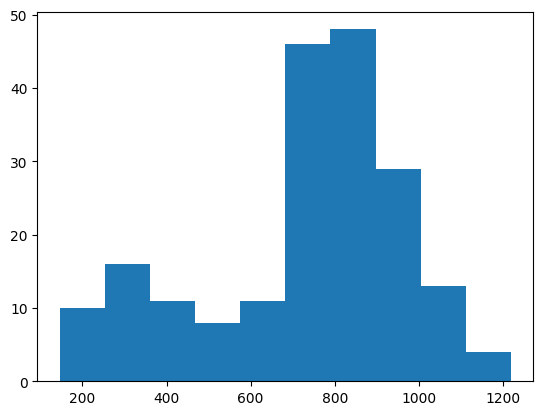

In [64]:
plt.hist(y_test - y_pred_ridge)

##### Linear Regression model with hyperparameter tuning.

In [53]:
pipeline2 = Pipeline([
    ('prep', PolynomialFeatures()),
    ('scale', StandardScaler()),
    ('model', LinearRegression())
])

parm_grid2 = {
    'prep__degree' : (1,5),
    'prep__interaction_only' : [True, False],
    'prep__include_bias' : [True, False],
    'prep__order' : ['C', 'F'],
    'model__fit_intercept' : [True, False],
    'model__positive' : [True, False]
}

grid2 = GridSearchCV(pipeline2, parm_grid2, cv=5, n_jobs=4)
grid2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep', PolynomialFeatures()),
                                       ('scale', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=4,
             param_grid={'model__fit_intercept': [True, False],
                         'model__positive': [True, False],
                         'prep__degree': (1, 5),
                         'prep__include_bias': [True, False],
                         'prep__interaction_only': [True, False],
                         'prep__order': ['C', 'F']})

The best model parameters.

In [76]:
grid2.best_params_

{'model__fit_intercept': True,
 'model__positive': True,
 'prep__degree': 1,
 'prep__include_bias': True,
 'prep__interaction_only': True,
 'prep__order': 'F'}

$R^2$ score of the best model

In [77]:
grid2.score(X_train,y_train)

0.9045440077916282

Average $R^2$ score for cross-validation of the best model

In [78]:
grid2.best_score_

np.float64(-0.08042942849161565)

In [57]:
y_pred = grid2.predict(X_test)

Visualization of gold prices and model predictions.

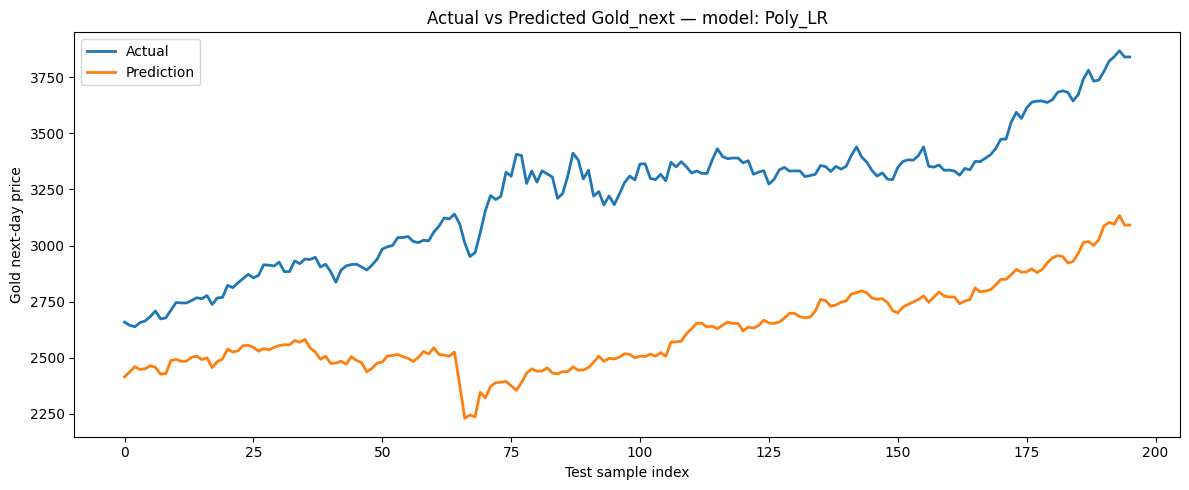

In [58]:
plot_predictions(y_pred, "Poly_LR")

Residual plot.

(array([15., 15., 17., 11., 34., 33., 43., 19.,  7.,  2.]),
 array([ 178.15719189,  265.435089  ,  352.71298612,  439.99088323,
         527.26878035,  614.54667746,  701.82457458,  789.10247169,
         876.38036881,  963.65826593, 1050.93616304]),
 <BarContainer object of 10 artists>)

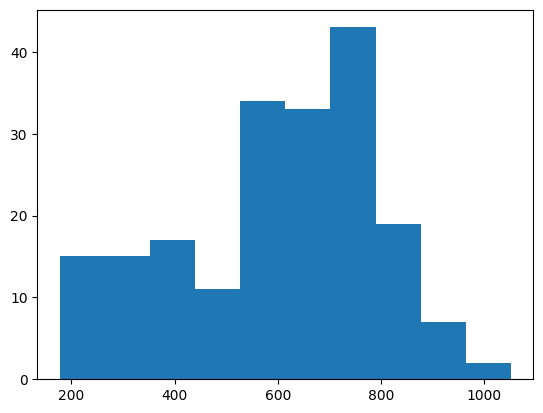

In [80]:
plt.hist(y_test - y_pred)

In [81]:
grid2.best_estimator_.named_steps['model'].coef_

array([  0.        , 213.22027117,   0.        , 234.9735958 ,
         0.        ,   0.        ,  30.62154753,   0.        ,
         0.        ])

In [82]:
grid2.best_estimator_.named_steps['model'].intercept_

np.float64(1544.8207303224654)

In [83]:
X_train.head()

Silver        Oil        SP500  Euro_STOXX_50          DAX  \
Date                                                                        
2010-01-04  17.440001  81.510002  1132.989990    4352.868250  8724.054531   
2010-01-05  17.781000  81.769997  1136.520020    4327.544230  8665.345250   
2010-01-06  18.163000  83.180000  1137.140015    4335.124196  8691.869213   
2010-01-07  18.333000  82.660004  1141.689941    4305.919241  8618.538874   
2010-01-08  18.458000  82.750000  1144.979980    4349.051121  8700.854282   

            USDPLN    EURUSD    USDGBP  
Date                                    
2010-01-04  2.8250  1.442398  1.611370  
2010-01-05  2.8453  1.436596  1.599079  
2010-01-06  2.8379  1.440403  1.602384  
2010-01-07  2.8673  1.431803  1.593397  
2010-01-08  2.8182  1.441109  1.602410

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(X_train['Oil'], y_train)

In [ ]:
r2 = r_value**2
r2

np.float64(0.051553040796129865)

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(X_test['Oil'], y_test)

In [ ]:
r2 = r_value**2
r2

np.float64(0.5465470117559661)

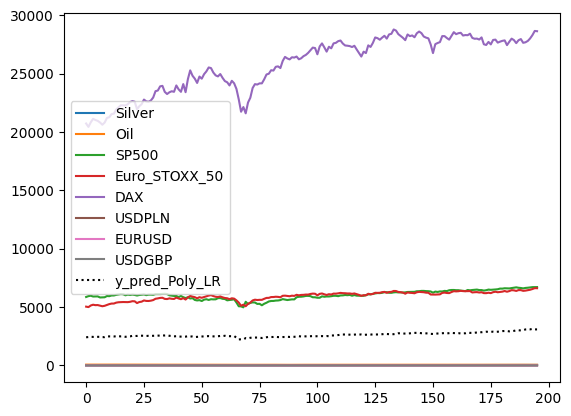

In [67]:
for x in X_train.columns:
    plt.plot(range(len(y_test)), X_test[x], label=x)

plt.plot(range(len(y_test)), y_pred, label='y_pred_Poly_LR', c='black', linestyle='dotted')
plt.title
plt.legend()
plt.show()

##### Model RandomForestClassifier

Transforming the Y-value of the training and test sets into classes 0 and 1 to ensure the model works correctly.

- 0 - the price of gold decreases
- 1 - the price of gold increases

In [76]:
y_train_disc = (train_df['Gold'].shift(-1) > train_df['Gold']).astype(int)  # 1 if price goes up, 0 if down
y_test_disc = (test_df['Gold'].shift(-1) > test_df['Gold']).astype(int)

In [71]:
tree_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', RandomForestClassifier())
])

tree_grid = {
    "tree__n_estimators" : [10,20,30,50],
    "tree__criterion" : ['gini', 'entropy', 'log_loss'],
    "tree__max_depth" : [2,4,10, None],
    "tree__min_samples_split" : [2,4,6],
    "tree__min_samples_leaf" : [1,2,3,4],
    "tree__max_features" : ['sqrt', 'log2', None]
}

grid_tree = GridSearchCV(tree_pipe,tree_grid, cv=5, n_jobs=4)
grid_tree.fit(X_train,y_train_disc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'tree__criterion': ['gini', 'entropy', 'log_loss'],
                         'tree__max_depth': [2, 4, 10, None],
                         'tree__max_features': ['sqrt', 'log2', None],
                         'tree__min_samples_leaf': [1, 2, 3, 4],
                         'tree__min_samples_split': [2, 4, 6],
                         'tree__n_estimators': [10, 20, 30, 50]})

The best model parameters.

In [72]:
grid_tree.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('scaler', StandardScaler()),
  ('tree', RandomForestClassifier())],
 'estimator__transform_input': None,
 'estimator__verbose': False,
 'estimator__scaler': StandardScaler(),
 'estimator__tree': RandomForestClassifier(),
 'estimator__scaler__copy': True,
 'estimator__scaler__with_mean': True,
 'estimator__scaler__with_std': True,
 'estimator__tree__bootstrap': True,
 'estimator__tree__ccp_alpha': 0.0,
 'estimator__tree__class_weight': None,
 'estimator__tree__criterion': 'gini',
 'estimator__tree__max_depth': None,
 'estimator__tree__max_features': 'sqrt',
 'estimator__tree__max_leaf_nodes': None,
 'estimator__tree__max_samples': None,
 'estimator__tree__min_impurity_decrease': 0.0,
 'estimator__tree__min_samples_leaf': 1,
 'estimator__tree__min_samples_split': 2,
 'estimator__tree__min_weight_fraction_leaf': 0.0,
 'estimator__tree__monotonic_cst': None,
 'estimator__tree__n_estimators': 100,
 'estimator_

In [73]:
grid_tree.best_estimator_.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 RandomForestClassifier(criterion='log_loss', max_depth=2,
                                        max_features='log2', min_samples_leaf=4,
                                        n_estimators=20))])>

In [74]:
y_tree_pred = grid_tree.predict(X_test)

Visualization of gold prices and model predictions.

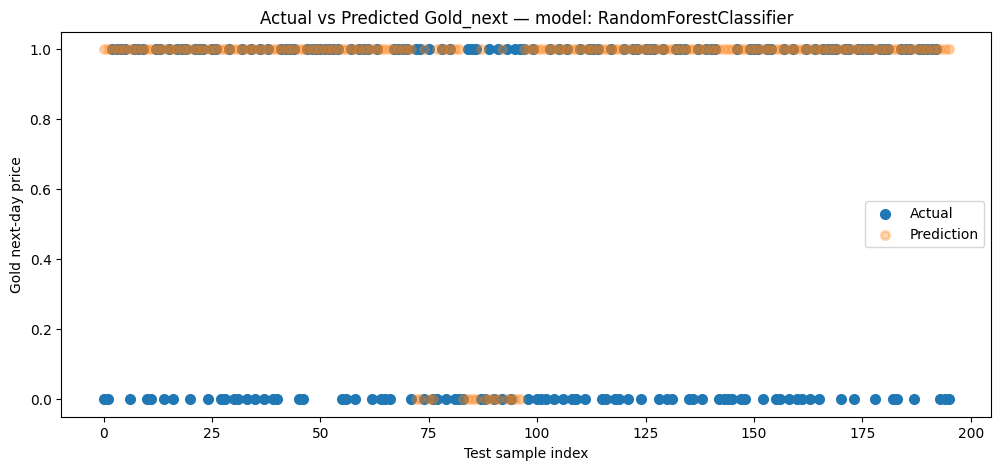

In [165]:
plt.figure(figsize=(12,5))
plt.scatter(range(len(y_test_disc)), y_test_disc, label='Actual', linewidth=2)
plt.scatter(range(len(y_test_disc)), y_tree_pred, label='Prediction', linewidth=2, alpha=0.3)
plt.title(f'Actual vs Predicted Gold_next — model: RandomForestClassifier')
plt.xlabel('Test sample index')
plt.ylabel('Gold next-day price')
plt.legend()
plt.show()

In [80]:
y_tree_pred_proba = grid_tree.predict_proba(X_test)

In [81]:
y_treepred_proba = y_tree_pred_proba.copy()
y_treepred_proba >= 0.51

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [Fal

tuning prediction results. Experimental method.

In [226]:
prdictions = [1 if prob[1] > 0.535 else 0 for prob in y_treepred_proba]
prdictions

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [227]:
y_test_disc.values

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [228]:
np.array(prdictions)

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [229]:
errorrrr = prdictions - y_tree_pred

In [230]:
zeros = [i for i in errorrrr if i == 0]
ones = [i for i in errorrrr if i == 1]

print(len(zeros)/len(errorrrr), len(ones)/len(errorrrr), sep='\n')

0.8979591836734694
0.0


Visualization of gold prices and model predictions.

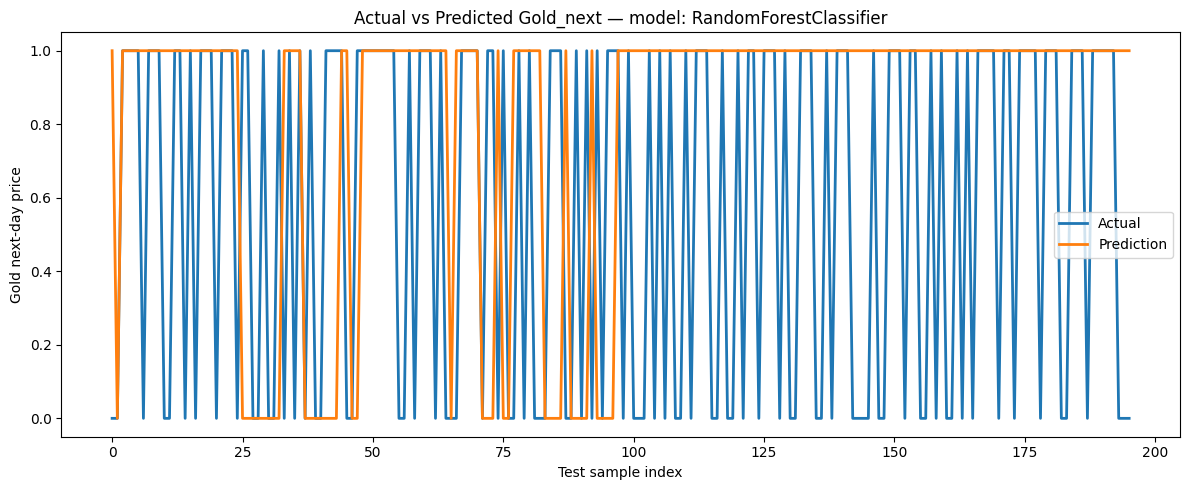

In [231]:
plt.figure(figsize=(12,5))
plt.plot(range(len(y_test_disc)), y_test_disc, label='Actual', linewidth=2)
plt.plot(range(len(y_test_disc)), prdictions, label='Prediction', linewidth=2)
plt.title(f'Actual vs Predicted Gold_next — model: RandomForestClassifier')
plt.xlabel('Test sample index')
plt.ylabel('Gold next-day price')
plt.legend()
plt.tight_layout()
plt.show()

Manual tuning did not work.

##### Model DecisionTreeRegressor.

In [95]:
tree_regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeRegressor())
])

parm_grid_dtr = {
    'tree__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'tree__splitter' : ['best', 'random'],
    'tree__max_depth' : [2,3,4,5,6,7,8,9,10],
    'tree__max_features' : ['sqrt', 'log2']
}
grid_dtr = GridSearchCV(tree_regressor, parm_grid_dtr, cv=5, n_jobs=4)
grid_dtr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', DecisionTreeRegressor())]),
             n_jobs=4,
             param_grid={'tree__criterion': ['squared_error', 'friedman_mse',
                                             'absolute_error', 'poisson'],
                         'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'tree__max_features': ['sqrt', 'log2'],
                         'tree__splitter': ['best', 'random']})

The best model parameters.

In [96]:
grid_dtr.best_params_

{'tree__criterion': 'poisson',
 'tree__max_depth': 3,
 'tree__max_features': 'log2',
 'tree__splitter': 'best'}

In [97]:
y_pred_dtr = grid_dtr.predict(X_test)

Visualization of gold prices and model predictions.

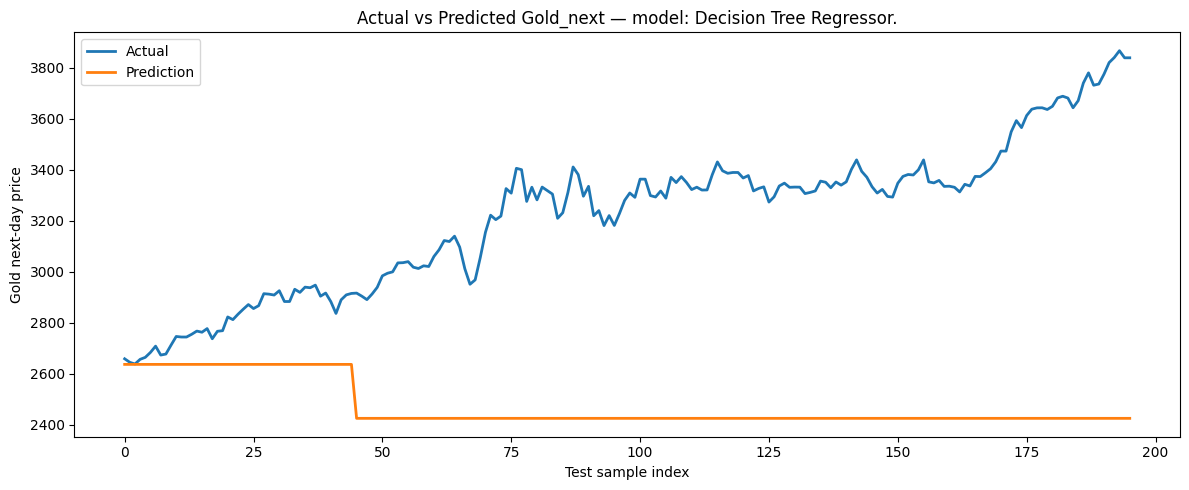

In [99]:
plot_predictions(y_pred_dtr, "Decision Tree Regressor.")

#### Adding Lags to gold prices and rolling mean

| Technique | Purpose | What it gives the model |
|------------|----------|--------------------------|
| **Lag features** | Capture the influence of past values | Memory of short-term dynamics and temporal dependencies |
| **Rolling mean (moving average)** | Smooth out short-term fluctuations and highlight trends | Context of the long-term trend and overall direction |

**In short:**
- **Lags** help the model “remember” how the price has been changing recently.  
- **Rolling means** help it understand whether the market is in an upward or downward trend.  
- **Together**, they make time-series models (e.g., for gold prices) more aware of both short-term momentum and long-term patterns.


In [69]:
TEST_SIZE_RATIO = 0.20
TS_CV_SPLITS = 5
RANDOM_STATE = 42
data = pd.read_csv("data/financial_data_usd_2010-01-01_2025-10-03.csv", parse_dates=['Date'])
datd = data.sort_values('Date').reset_index(drop=True)
# lag features (gold)
lags = [1,2,3,7,14]
for l in lags:
    data[f'Gold_lag_{l}'] = data['Gold'].shift(l)

In [70]:
# rolling means
windows = [3,7,14,30]
for w in windows:
    data[f'Gold_roll_mean_{w}'] = data['Gold'].rolling(w).mean()

# pct changes for assets
assets = ['Gold','Silver','Oil','SP500','Euro_STOXX_50','DAX','USDPLN','EURUSD','USDGBP']
for a in assets:
    if a in data.columns:
        data[f'{a}_pct_1'] = data[a].pct_change(1)
        data[f'{a}_pct_7'] = data[a].pct_change(7)

In [71]:
# date features
data['dayofweek'] = data['Date'].dt.dayofweek
data['month'] = data['Date'].dt.month

# target: next day's gold price
data['Gold_next'] = data['Gold'].shift(-1)

# drop NaNs resulted from shifts/rolling
data = data.dropna().reset_index(drop=True)
print("After feature engineering:", data.shape)

After feature engineering: (4078, 40)


In [72]:
# ---------- Prepare X, y and time-based split ----------
exclude = ['Gold','Gold_next', 'Date']
features = [c for c in data.columns if c not in exclude]
X = data[features]
y = data['Gold_next']


In [73]:
split_idx = int(len(data) * (1 - TEST_SIZE_RATIO))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = data['Date'].iloc[split_idx:].reset_index(drop=True)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (3262, 37) Test size: (816, 37)


#### Various models with hyperparameter tuning

In [74]:
models = {}
param_grids = {}

In [75]:
# Decision Tree
models['DecisionTree'] = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grids['DecisionTree'] = {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

# Random Forest
models['RandomForest'] = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=4)
param_grids['RandomForest'] = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [5, 10, None],
    'model__min_samples_leaf': [1, 2, 5]
}

# Gradient Boosting (sklearn)
models['GradientBoosting'] = GradientBoostingRegressor(random_state=RANDOM_STATE)
param_grids['GradientBoosting'] = {
    'model__n_estimators': [100, 300],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5]
}

# XGBoost if available
models['XGBoost'] = XGBRegressor(random_state=RANDOM_STATE, verbosity=0, n_jobs=4)
param_grids['XGBoost'] = {
    'model__n_estimators': [100, 300],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5]
}

#### Gridsearch and prediction for provided models.

In [76]:
# ---------- Helper: fit GridSearchCV for each model ----------
tscv = TimeSeriesSplit(n_splits=TS_CV_SPLITS)
results_summary = []

for name, estimator in models.items():
    print("\n--- Running model:", name)
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # scaling is harmless; tree-based not required but fine for comparability
        ('model', estimator)
    ])

    grid = param_grids[name]

    gscv = GridSearchCV(pipe, grid, cv=tscv, scoring='neg_mean_absolute_error',
                        n_jobs=4, verbose=2, refit=True)

    # Warning for runtime
    print(f"Fitting GridSearch for {name} — this can take a while depending on grid size and data length.")
    gscv.fit(X_train, y_train)

    best = gscv.best_estimator_
    print(f"{name} best params:", gscv.best_params_)

    # Predict and evaluate on test set
    y_pred = best.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_summary.append({
        'model': name,
        'best_params': gscv.best_params_,
        'mse': mse,
        'mae': mae,
        'r2': r2
    })

    # Save predictions sample
    pred_df = pd.DataFrame({
        'Date': dates_test,
        'Gold_actual': y_test.values,
        f'Gold_pred_{name}': y_pred
    })
    
    # Feature importances (for tree-based)
    try:
        model_step = best.named_steps['model']
        if hasattr(model_step, "feature_importances_"):
            importances = model_step.feature_importances_
            fi = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        else:
            # for linear models we could dump coef_
            pass
    except Exception as e:
        print("Couldn't extract feature importances for", name, e)


--- Running model: DecisionTree
Fitting GridSearch for DecisionTree — this can take a while depending on grid size and data length.
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.0s
[CV] END model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5; 

Summary dataframe of the best models parameters with losses.

In [ ]:
res_df = pd.DataFrame(results_summary).sort_values('mae')
print("\nModels comparison:")
print(res_df)


Models comparison:
              model                                        best_params  \
2  GradientBoosting  {'model__learning_rate': 0.1, 'model__max_dept...   
3           XGBoost  {'model__learning_rate': 0.1, 'model__max_dept...   
1      RandomForest  {'model__max_depth': None, 'model__min_samples...   
0      DecisionTree  {'model__max_depth': None, 'model__min_samples...   

             mse         mae        r2  
2  472600.783758  446.520842 -0.479392  
3  480758.251660  452.973963 -0.504928  
1  483339.866641  456.571827 -0.513009  
0  487221.073962  458.448540 -0.525158  


Plots: Actual vs Predicted for each model and residuals.

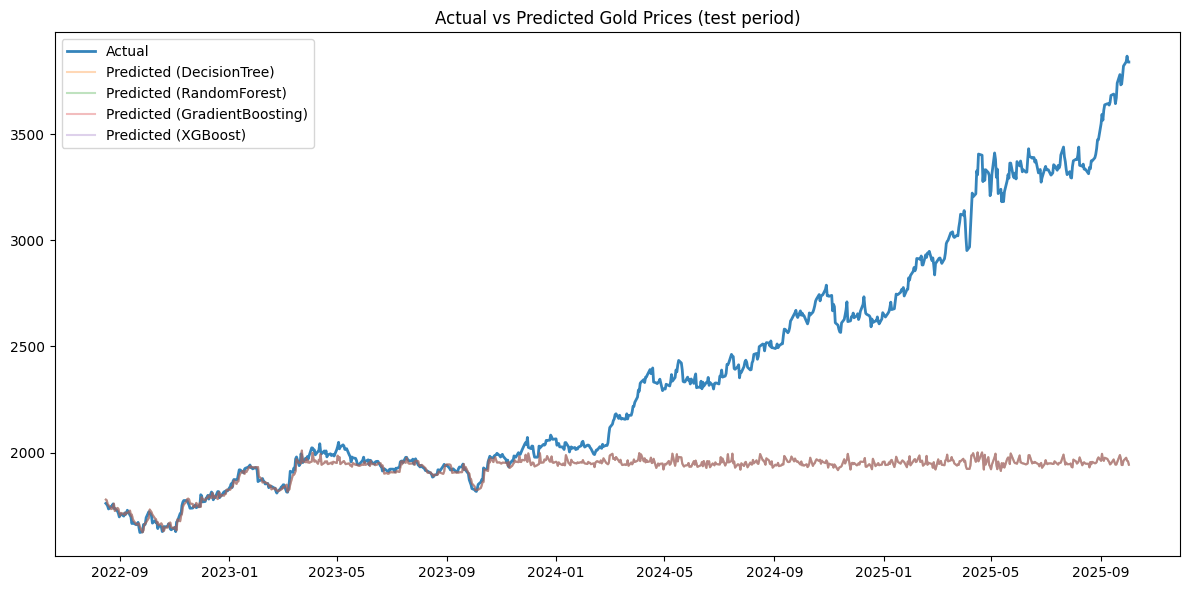

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Actual', linewidth=2, alpha=0.9)

for name in models.keys():
    plt.plot(pred_df['Date'], pred_df.iloc[:,2], label=f'Predicted ({name})', alpha=0.3)

plt.title('Actual vs Predicted Gold Prices (test period)')
plt.legend()
plt.tight_layout()
plt.show()

Residuals histograms and MAE bar chart.

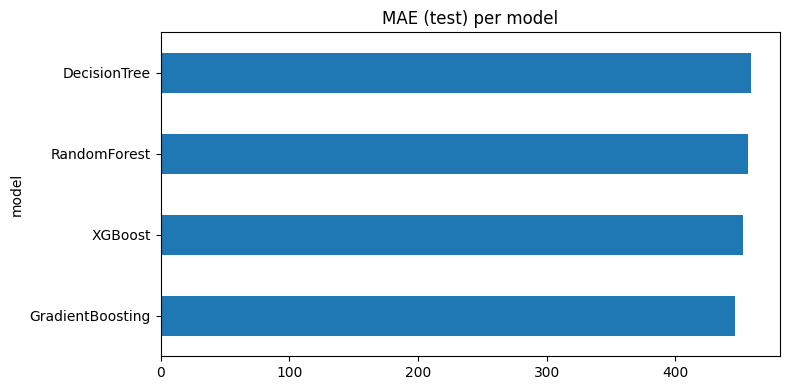

In [61]:
mae_vals = res_df.set_index('model')['mae']
plt.figure(figsize=(8,4))
mae_vals.plot(kind='barh')
plt.title('MAE (test) per model')
plt.tight_layout()
plt.show()

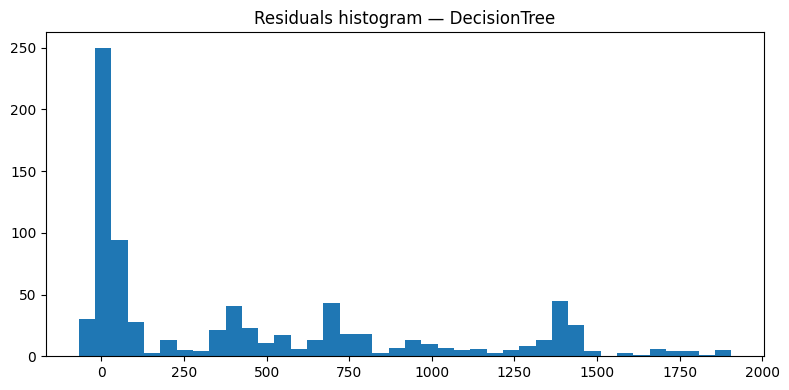

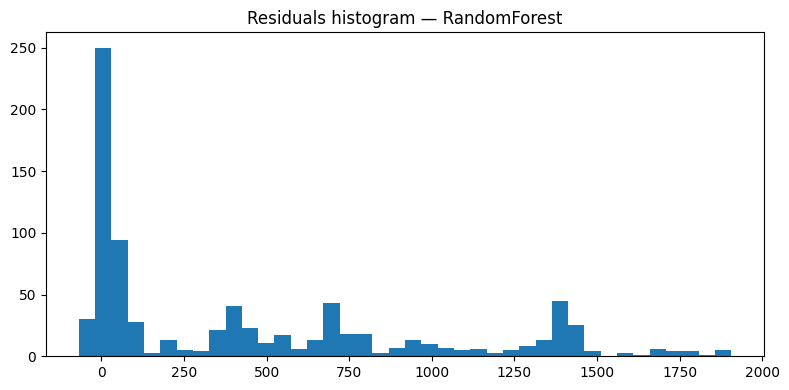

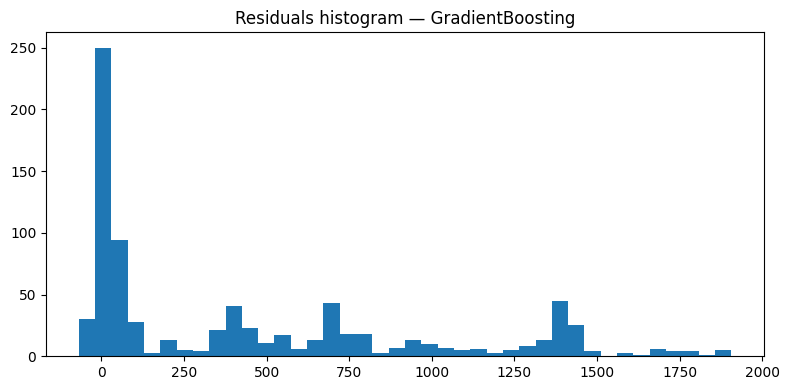

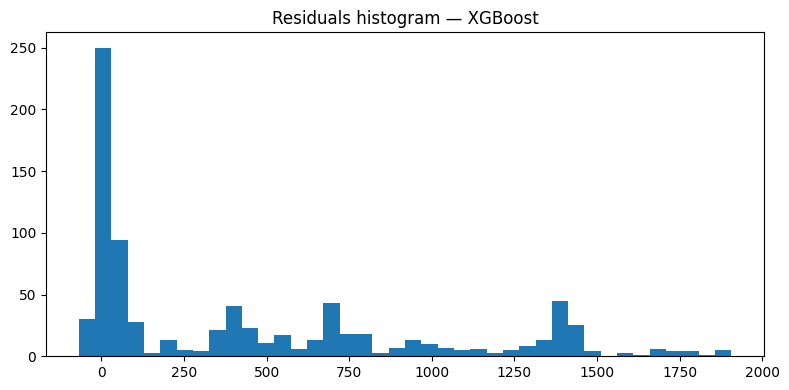

In [62]:

for name in models.keys():
    p = pred_df
    residuals = p['Gold_actual'].values - p.iloc[:,2].values
    plt.figure(figsize=(8,4))
    plt.hist(residuals, bins=40)
    plt.title(f'Residuals histogram — {name}')
    plt.tight_layout()
    plt.show()


#### Abandoning timeseries, data entered into the model in a random manner.

In [3]:
TEST_SIZE = 0.2
POLY_DEGREE = 3
RANDOM_STATE = 42
# ------------------------------------------
data = prepared_df.copy()

In [4]:
# Lags for Gold
lags = [1, 2, 3, 7, 14]
for l in lags:
    data[f'Gold_lag_{l}'] = data['Gold'].shift(l)

In [5]:
# Rolling means for Gold
windows = [3, 7, 14, 30]
for w in windows:
    data[f'Gold_roll_mean_{w}'] = data['Gold'].rolling(w).mean()

In [6]:
# pct changes for assets (if columns exist)
assets = ['Gold', 'Silver', 'Oil', 'SP500', 'Euro_STOXX_50', 'DAX', 'USDPLN', 'EURUSD', 'USDGBP']
for a in assets:
    if a in data.columns:
        data[f'{a}_pct_1'] = data[a].pct_change(1)
        data[f'{a}_pct_7'] = data[a].pct_change(7)

In [7]:
# Target: Gold next day (absolute value), then remove Date column per request
data['Gold_next'] = data['Gold'].shift(-1)

In [8]:
# Drop Date column completely
if 'Date' in data.columns:
    data = data.drop(columns=['Date'])

In [9]:
# Drop rows with NaN from lags/rolling/pct
data = data.dropna().reset_index(drop=True)

print("After feature engineering, rows:", len(data), "columns:", data.shape[1])

After feature engineering, rows: 4078 columns: 37


In [10]:
# Features and target
TARGET = "Gold_next"  # we predict next-day Gold, then evaluate vs actual Gold_next
X = data.drop(columns=[TARGET, 'Gold'])  # keep numeric features (drop original 'Gold' to avoid leakage to absolute value)
y = data[TARGET].values

In [11]:
# Train/test split with shuffle=True as requested
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3262, 35) Test shape: (816, 35)


In [12]:
# 2) Define models
models_to_run = {}

In [13]:
# Linear models (no heavy grid)
models_to_run['LinearRegression'] = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])

In [14]:
# Ridge and Lasso (we will do simple grid for alpha)
models_to_run['Ridge'] = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(random_state=RANDOM_STATE))])
models_to_run['Lasso'] = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(random_state=RANDOM_STATE, max_iter=10000))])

In [15]:
# Polynomial + Linear / Ridge / Lasso (degree=3)
models_to_run['Poly_LR'] = Pipeline([('poly', PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)),
                                     ('scaler', StandardScaler()), ('lr', LinearRegression())])
models_to_run['Poly_Ridge'] = Pipeline([('poly', PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)),
                                       ('scaler', StandardScaler()), ('ridge', Ridge(random_state=RANDOM_STATE))])
models_to_run['Poly_Lasso'] = Pipeline([('poly', PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)),
                                       ('scaler', StandardScaler()), ('lasso', Lasso(random_state=RANDOM_STATE, max_iter=10000))])

In [16]:
# Tree-based models (we'll use GridSearchCV for these)
models_tree = {
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost' : XGBRegressor(random_state=RANDOM_STATE, verbosity=1)
}

In [17]:
# 3) Param grids
param_grids_tree = {
    'DecisionTree': {
        'model__max_depth': [None, 5, 10],
        'model__min_samples_leaf': [1, 3, 5]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10],
        'model__min_samples_leaf': [1, 3]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'XGBoost' : {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

In [18]:
# For Ridge/Lasso small grid on alpha
param_grid_ridge = {'ridge__alpha': [0.1, 1.0, 10.0]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0]}

In [19]:
# 4) Fit linear-type models (no GridSearch) except Ridge/Lasso (we'll GridSearch alpha)
results = []
fitted_models = {}

In [20]:
# Linear Regression
print("\nFitting LinearRegression...")
models_to_run['LinearRegression'].fit(X_train, y_train)
fitted_models['LinearRegression'] = models_to_run['LinearRegression']


Fitting LinearRegression...


In [21]:
# Poly LR
print("Fitting Poly (deg={}) + LinearRegression...".format(POLY_DEGREE))
models_to_run['Poly_LR'].fit(X_train, y_train)
fitted_models['Poly_LR'] = models_to_run['Poly_LR']

Fitting Poly (deg=3) + LinearRegression...


In [22]:
# Ridge GridSearch
print("GridSearch Ridge...")
gs_ridge = GridSearchCV(models_to_run['Ridge'], param_grid_ridge, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, refit=True, verbose=1)
gs_ridge.fit(X_train, y_train)
fitted_models['Ridge'] = gs_ridge.best_estimator_
best_ridge_params = gs_ridge.best_params_

GridSearch Ridge...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [23]:
# Lasso GridSearch
print("GridSearch Lasso...")
gs_lasso = GridSearchCV(models_to_run['Lasso'], param_grid_lasso, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, refit=True, verbose=1)
gs_lasso.fit(X_train, y_train)
fitted_models['Lasso'] = gs_lasso.best_estimator_
best_lasso_params = gs_lasso.best_params_

GridSearch Lasso...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [24]:
# Poly + Ridge/Lasso (GridSearch for alpha)
print("GridSearch Poly + Ridge/Lasso...")
poly_ridge_pipeline = models_to_run['Poly_Ridge']
poly_lasso_pipeline = models_to_run['Poly_Lasso']

gs_poly_ridge = GridSearchCV(poly_ridge_pipeline, {'ridge__alpha': [0.1, 1.0, 10.0]}, scoring='neg_mean_absolute_error', cv=5, n_jobs=2, refit=True, verbose=1)
gs_poly_ridge.fit(X_train, y_train)
fitted_models['Poly_Ridge'] = gs_poly_ridge.best_estimator_
best_poly_ridge_params = gs_poly_ridge.best_params_

gs_poly_lasso = GridSearchCV(poly_lasso_pipeline, {'lasso__alpha': [0.001, 0.01, 0.1, 1.0]}, scoring='neg_mean_absolute_error', cv=5, n_jobs=2, refit=True, verbose=1)
gs_poly_lasso.fit(X_train, y_train)
fitted_models['Poly_Lasso'] = gs_poly_lasso.best_estimator_
best_poly_lasso_params = gs_poly_lasso.best_params_

GridSearch Poly + Ridge/Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [25]:
# Evaluate linear-family models
linear_models = ['LinearRegression', 'Ridge', 'Lasso', 'Poly_LR', 'Poly_Ridge', 'Poly_Lasso']
for name in linear_models:
    model = fitted_models[name]
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'model': name, 'mse': mse, 'mae': mae, 'r2': r2, 'best_params': None})
    print(f"{name} -> MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.4f}")

LinearRegression -> MAE: 11.140, MSE: 265.276, R2: 0.9989
Ridge -> MAE: 11.450, MSE: 273.851, R2: 0.9989
Lasso -> MAE: 11.539, MSE: 282.257, R2: 0.9988
Poly_LR -> MAE: 86.561, MSE: 103177.052, R2: 0.5695
Poly_Ridge -> MAE: 17.805, MSE: 1348.680, R2: 0.9944
Poly_Lasso -> MAE: 11.183, MSE: 261.883, R2: 0.9989


In [26]:
# 5) Fit tree-based models with GridSearch
print("\nGridSearch for tree-based models (this may take some time)...")
for name, estimator in models_tree.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', estimator)])
    grid = param_grids_tree[name]
    gscv = GridSearchCV(pipe, grid, scoring='neg_mean_absolute_error', cv=5, verbose=2, refit=True)
    print(f"\nFitting {name} ...")
    gscv.fit(X_train, y_train)
    best = gscv.best_estimator_
    fitted_models[name] = best
    # Evaluate
    y_pred = best.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'model': name, 'mse': mse, 'mae': mae, 'r2': r2, 'best_params': gscv.best_params_})
    print(f"{name} best params: {gscv.best_params_}")
    print(f"{name} -> MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.4f}")



GridSearch for tree-based models (this may take some time)...

Fitting DecisionTree ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...model__max_depth=None, model__min_samples_leaf=1; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=1; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=1; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=1; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=1; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=3; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=3; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=3; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=3; total time=   0.0s
[CV] END ...model__max_depth=None, model__min_samples_leaf=3; total time=   0.0s
[CV] END ...model__max_depth=None, model_

In [27]:
# 6) Collect tree-grid best params and linear-grid params
# add best params for Ridge/Lasso combos
# update results for the linear ones with their best params where applicable
for r in results:
    if r['model'] == 'Ridge':
        r['best_params'] = best_ridge_params
    if r['model'] == 'Lasso':
        r['best_params'] = best_lasso_params
    if r['model'] == 'Poly_Ridge':
        r['best_params'] = best_poly_ridge_params
    if r['model'] == 'Poly_Lasso':
        r['best_params'] = best_poly_lasso_params


In [28]:
# 7) Final results table
final_df = pd.DataFrame(results).sort_values('mae').reset_index(drop=True).round(4)
print(final_df[['model', 'mae', 'mse', 'r2', 'best_params']])

              model      mae          mse      r2  \
0  LinearRegression  11.1405     265.2761  0.9989   
1        Poly_Lasso  11.1829     261.8826  0.9989   
2             Ridge  11.4500     273.8507  0.9989   
3             Lasso  11.5386     282.2566  0.9988   
4  GradientBoosting  12.3191     307.4687  0.9987   
5      RandomForest  12.4584     316.2093  0.9987   
6           XGBoost  12.4989     330.1658  0.9986   
7      DecisionTree  16.4991     577.3025  0.9976   
8        Poly_Ridge  17.8055    1348.6804  0.9944   
9           Poly_LR  86.5609  103177.0518  0.5695   

                                         best_params  
0                                               None  
1                              {'lasso__alpha': 1.0}  
2                              {'ridge__alpha': 0.1}  
3                              {'lasso__alpha': 1.0}  
4  {'model__learning_rate': 0.1, 'model__max_dept...  
5  {'model__max_depth': None, 'model__min_samples...  
6  {'model__learning_rate': 0.1


Best model by MAE: LinearRegression


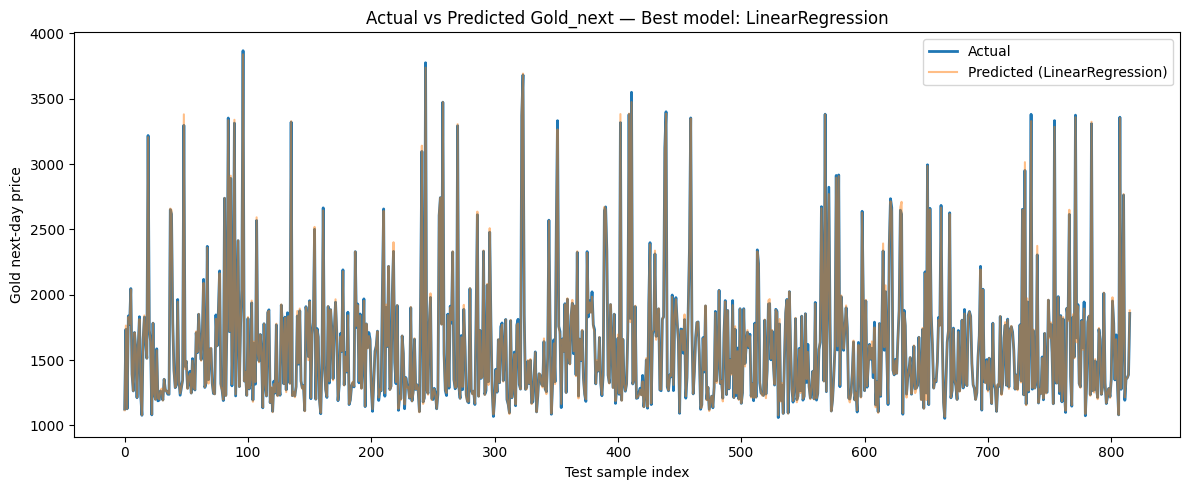

In [29]:
# 8) Plot: Actual vs Predicted for the best model (by MAE)
best_row = final_df.iloc[0]
best_model_name = best_row['model']
print("\nBest model by MAE:", best_model_name)

best_model = fitted_models[best_model_name]
y_best_pred = best_model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(range(len(y_test)), y_test, label='Actual', linewidth=2)
plt.plot(range(len(y_test)), y_best_pred, label=f'Predicted ({best_model_name})', alpha=0.5)
plt.title(f'Actual vs Predicted Gold_next — Best model: {best_model_name}')
plt.xlabel('Test sample index')
plt.ylabel('Gold next-day price')
plt.legend()
plt.tight_layout()
plt.show()

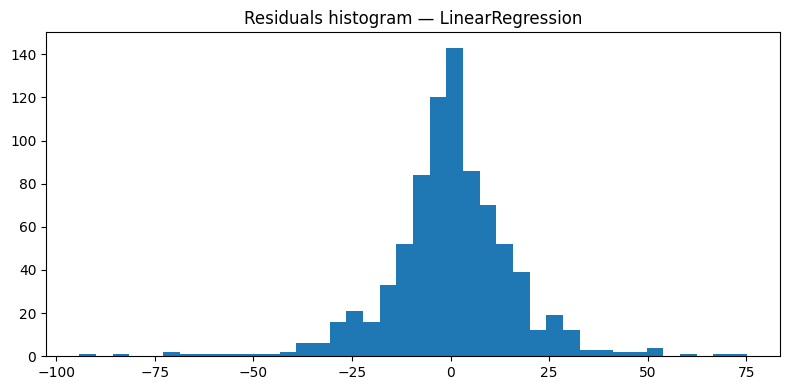

In [30]:
# Residuals histogram
residuals = y_test - y_best_pred
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40)
plt.title(f'Residuals histogram — {best_model_name}')
plt.tight_layout()
plt.show()

In [31]:
# 9) Save predictions of best model with original index reference
preds_df = pd.DataFrame({
    'Gold_actual': y_test,
    'Gold_pred': y_best_pred,
    'residual': residuals
})

In [32]:
display(preds_df)

Gold_actual    Gold_pred   residual
0    1125.099976  1116.198479   8.901497
1    1734.900024  1764.131176 -29.231152
2    1127.300049  1126.779387   0.520662
3    1837.699951  1828.935998   8.763953
4    1773.800049  1778.670586  -4.870537
..           ...          ...        ...
811  1192.599976  1214.744723 -22.144747
812  1358.800049  1355.909116   2.890933
813  1363.900024  1362.653277   1.246748
814  1388.199951  1387.639209   0.560742
815  1857.099976  1879.628850 -22.528875

[816 rows x 3 columns]

In [33]:
fitted_models

{'LinearRegression': Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())]),
 'Poly_LR': Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                 ('scaler', StandardScaler()), ('lr', LinearRegression())]),
 'Ridge': Pipeline(steps=[('scaler', StandardScaler()),
                 ('ridge', Ridge(alpha=0.1, random_state=42))]),
 'Lasso': Pipeline(steps=[('scaler', StandardScaler()),
                 ('lasso', Lasso(max_iter=10000, random_state=42))]),
 'Poly_Ridge': Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                 ('scaler', StandardScaler()),
                 ('ridge', Ridge(alpha=10.0, random_state=42))]),
 'Poly_Lasso': Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                 ('scaler', StandardScaler()),
                 ('lasso', Lasso(max_iter=10000, random_state=42))]),
 'DecisionTree': Pipeline(steps=[('scaler', StandardScaler()),
                

In [34]:
rid = fitted_models['Ridge'].predict(X_test)
laso = fitted_models['Lasso'].predict(X_test)
plr = fitted_models['Poly_LR'].predict(X_test)
pr = fitted_models['Poly_Ridge'].predict(X_test)
pl = fitted_models['Poly_Lasso'].predict(X_test)
dt = fitted_models['DecisionTree'].predict(X_test)
rf = fitted_models['RandomForest'].predict(X_test)
gb = fitted_models['GradientBoosting'].predict(X_test)
xgb = fitted_models['XGBoost'].predict(X_test)


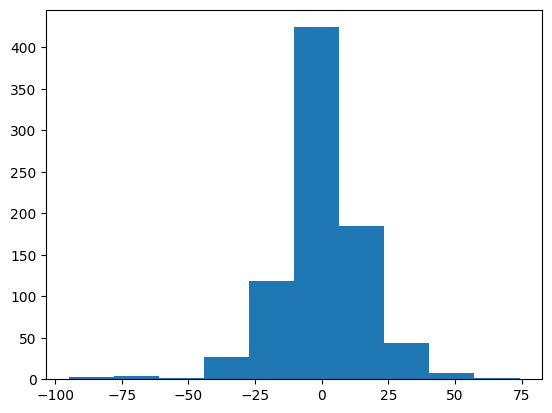

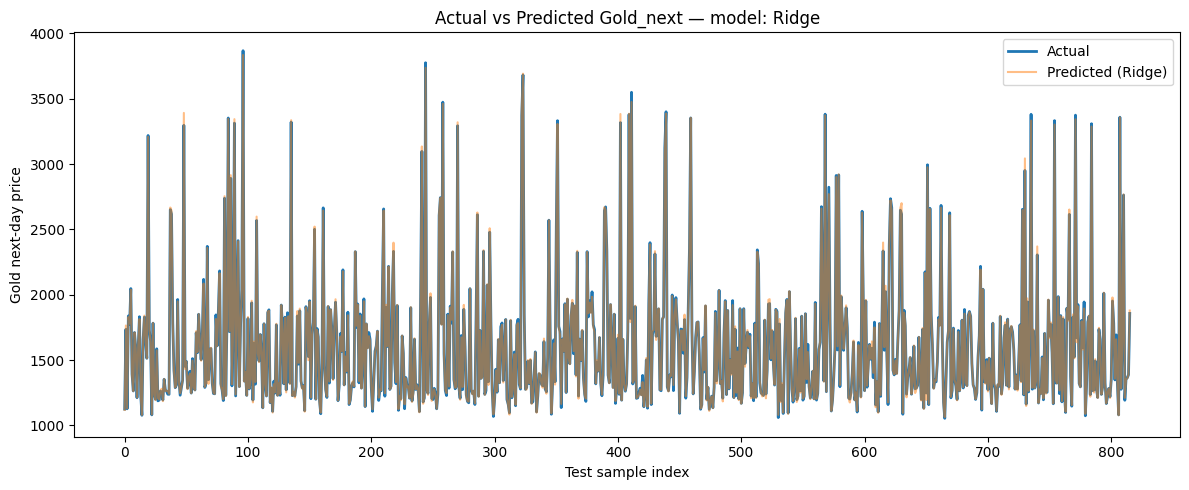

In [35]:
def plot_res(model, label:str):
    resid = y_test - model
    plt.hist(resid)
    plt.figure(figsize=(12,5))
    plt.plot(range(len(y_test)), y_test, label='Actual', linewidth=2)
    plt.plot(range(len(y_test)), model, label=f'Predicted ({label})', alpha=0.5)
    plt.title(f'Actual vs Predicted Gold_next — model: {label}')
    plt.xlabel('Test sample index')
    plt.ylabel('Gold next-day price')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_res(rid, "Ridge")

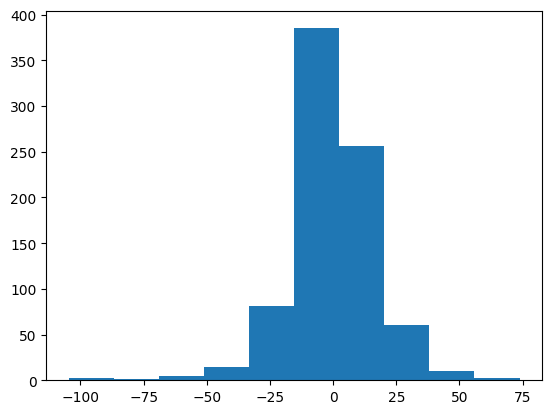

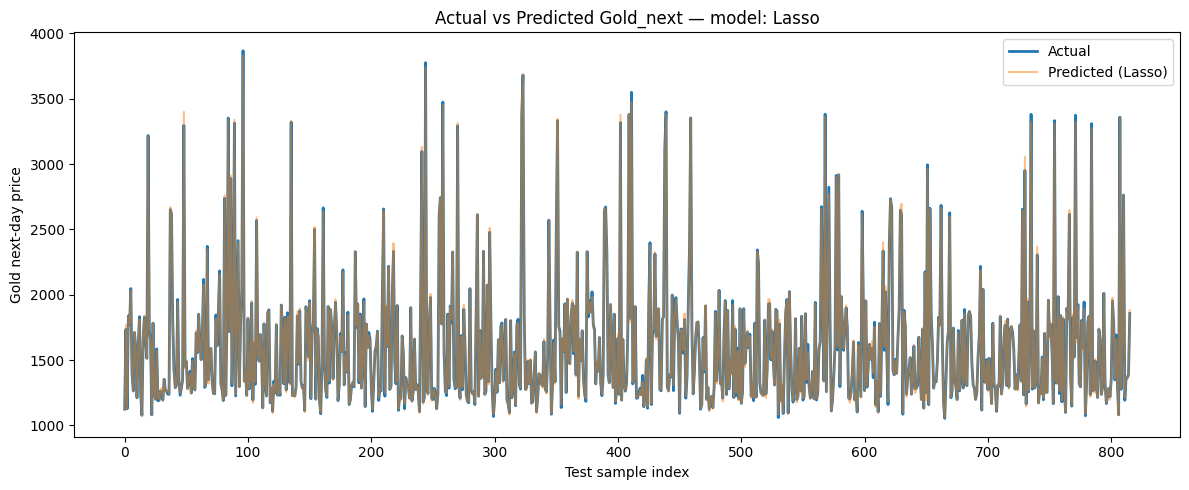

In [36]:
plot_res(laso, "Lasso")

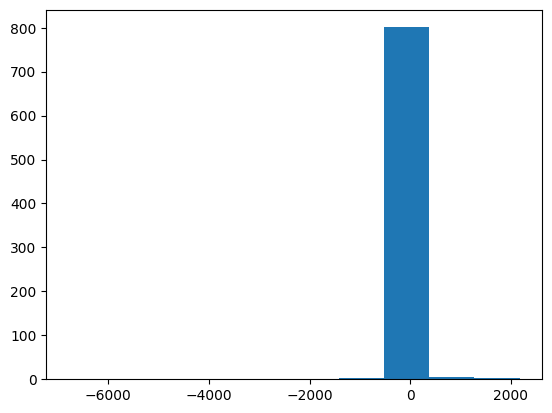

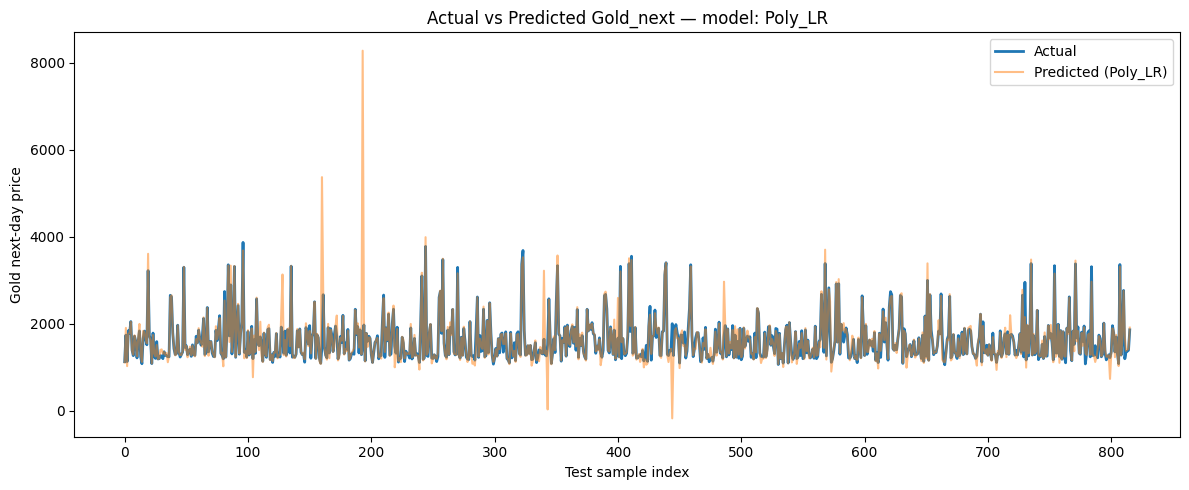

In [37]:
plot_res(plr, "Poly_LR")

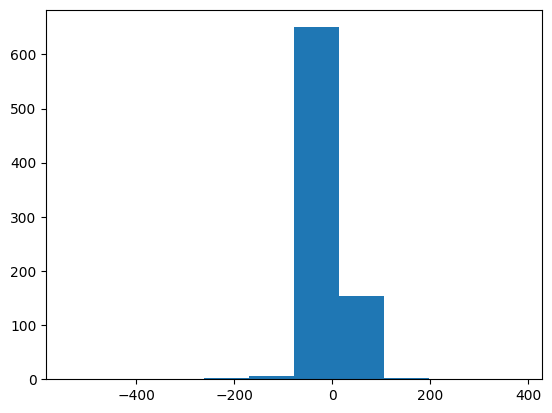

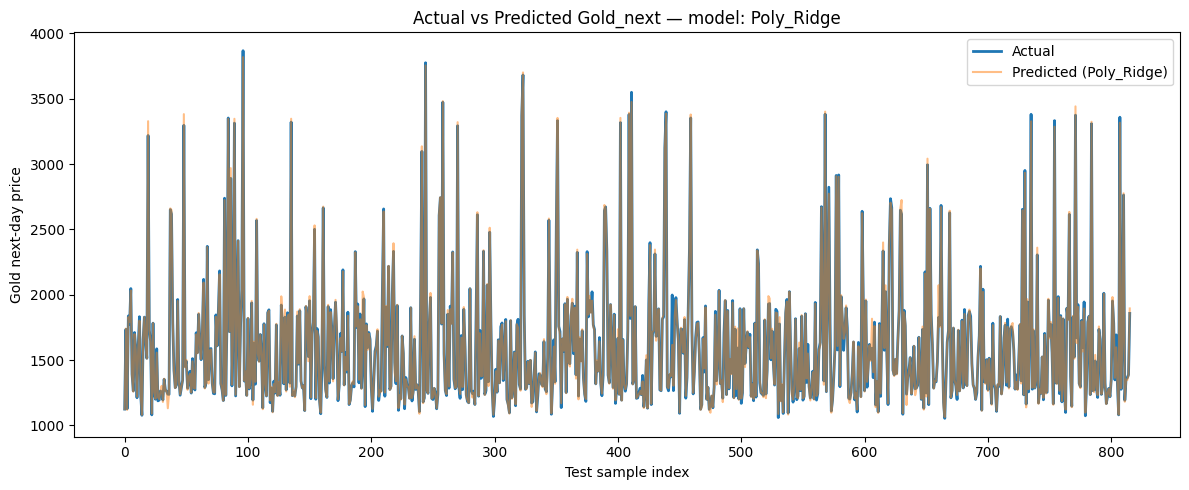

In [38]:
plot_res(pr, "Poly_Ridge")

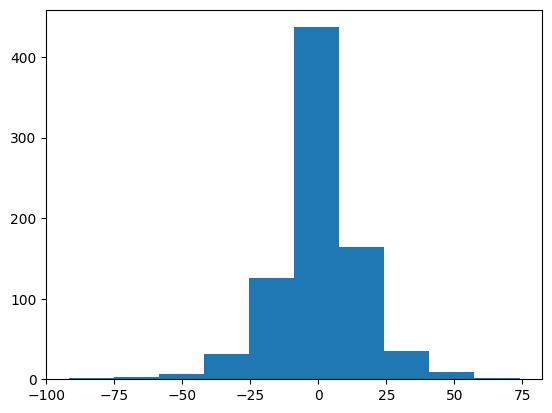

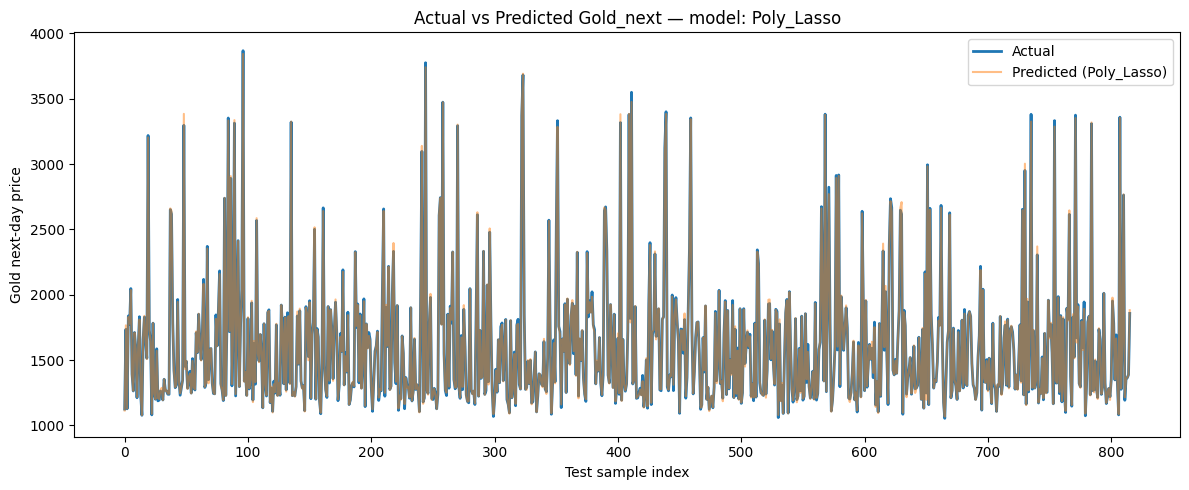

In [39]:
plot_res(pl, "Poly_Lasso")

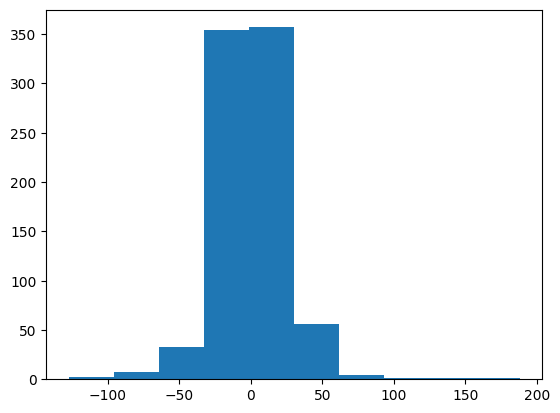

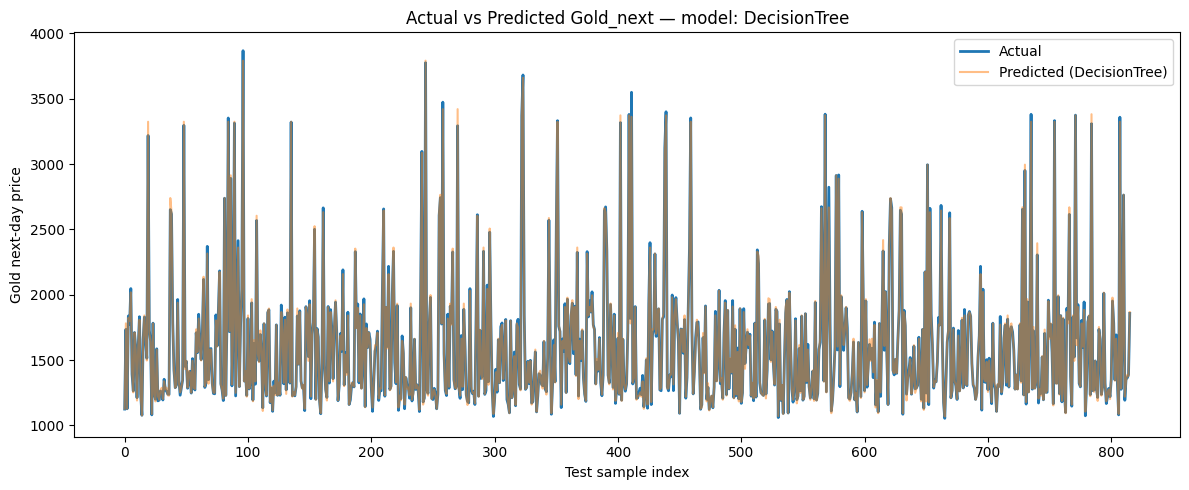

In [40]:
plot_res(dt, "DecisionTree")

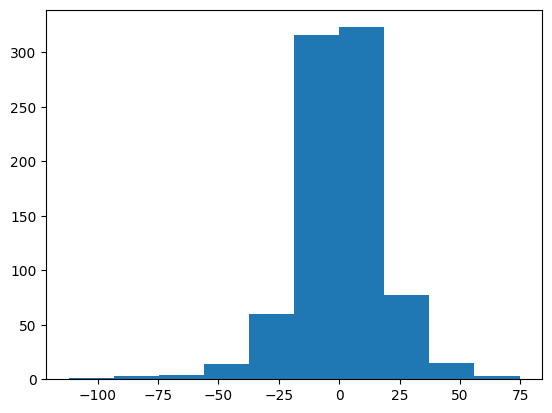

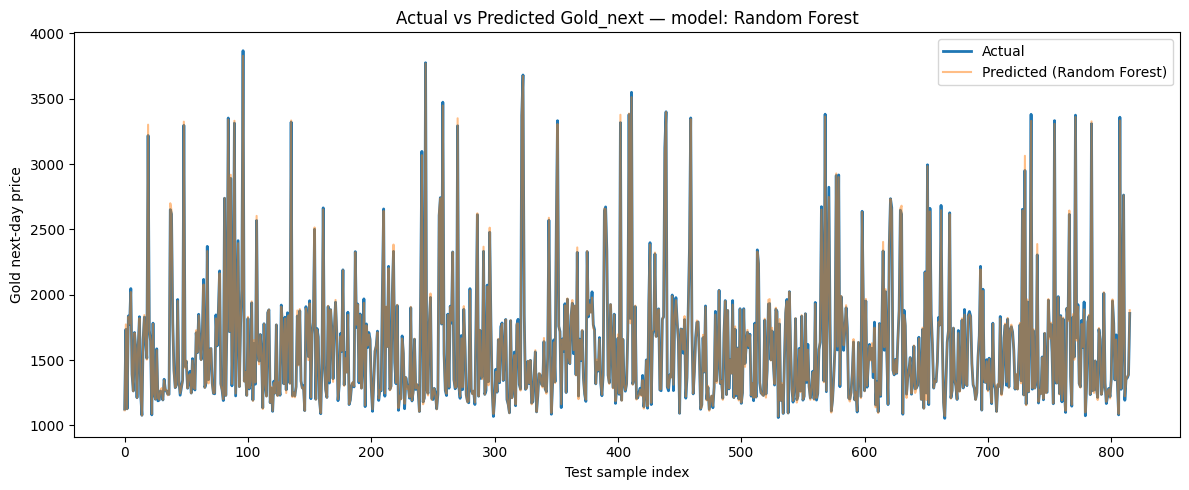

In [41]:
plot_res(rf, "Random Forest")

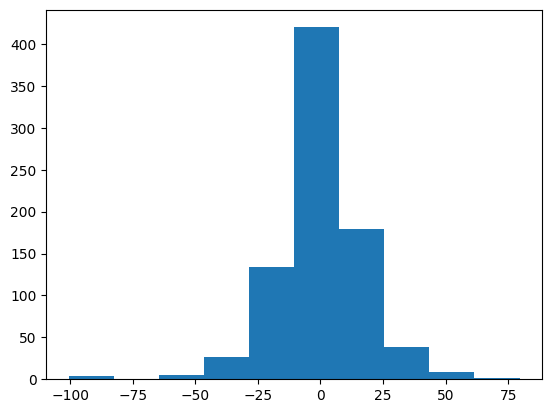

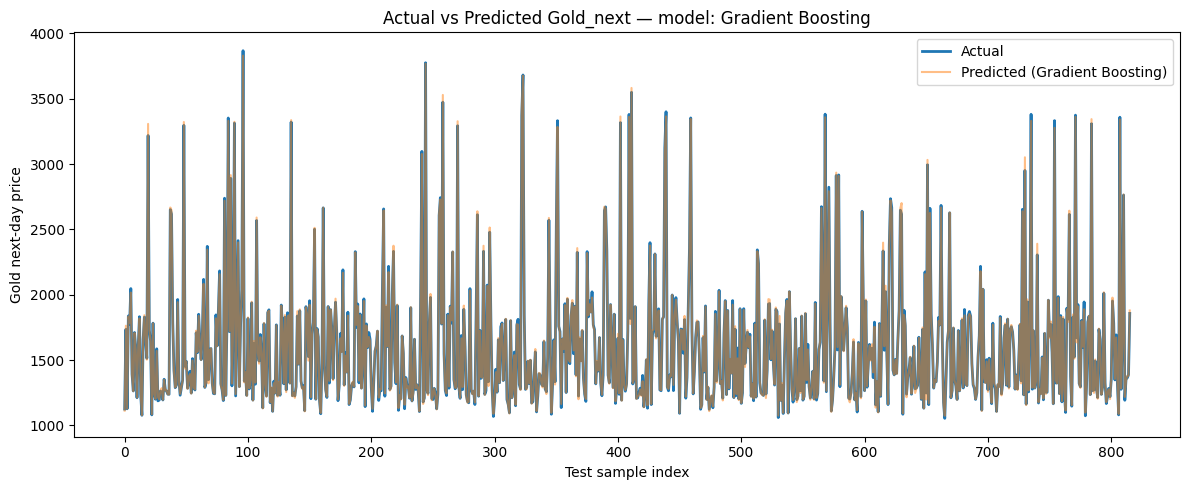

In [42]:
plot_res(gb, "Gradient Boosting")

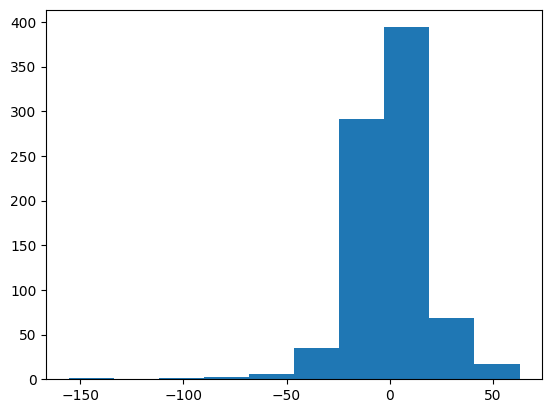

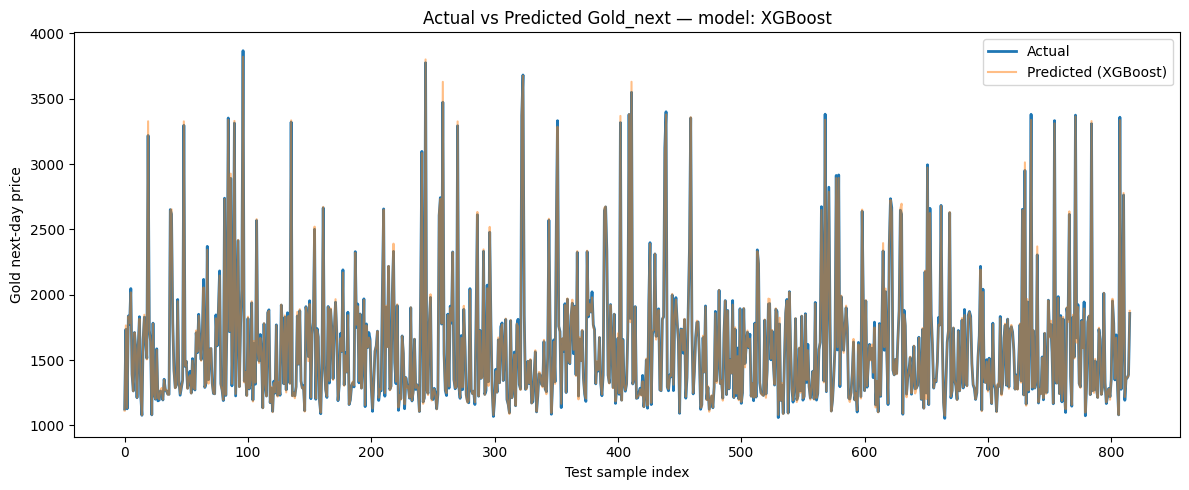

In [43]:
plot_res(xgb, "XGBoost")

In [44]:
results_df = pd.DataFrame(results).round(4)

In [45]:
results_df

model          mse      mae      r2  \
0  LinearRegression     265.2761  11.1405  0.9989   
1             Ridge     273.8507  11.4500  0.9989   
2             Lasso     282.2566  11.5386  0.9988   
3           Poly_LR  103177.0518  86.5609  0.5695   
4        Poly_Ridge    1348.6804  17.8055  0.9944   
5        Poly_Lasso     261.8826  11.1829  0.9989   
6      DecisionTree     577.3025  16.4991  0.9976   
7      RandomForest     316.2093  12.4584  0.9987   
8  GradientBoosting     307.4687  12.3191  0.9987   
9           XGBoost     330.1658  12.4989  0.9986   

                                         best_params  
0                                               None  
1                              {'ridge__alpha': 0.1}  
2                              {'lasso__alpha': 1.0}  
3                                               None  
4                             {'ridge__alpha': 10.0}  
5                              {'lasso__alpha': 1.0}  
6  {'model__max_depth': 10, 'model__min_samples_l...  
7  {'model__max_depth': None, 'model__min_samples...  
8  {'model__learning_rate': 0.1, 'model__max_dept...  
9  {'model__learning_rate': 0.1, 'model__max_dept...

#### Summary

  This project applies regression and ensemble models to predict gold prices. Experiments revealed that while models achieve near-perfect R² (≈0.999) under random validation, they collapse under true time-series testing (R² between –0.525 and –0.479). The study highlights the critical impact of validation strategy on performance interpretation and shows how non-stationary data can mislead model evaluation. The work emphasizes careful temporal validation and recommends routes for improving robustness and interpretability.

#### Model Evaluation Metrics for Regression

##### 📊 Overview
MSE, MAE, and R² are fundamental metrics used to evaluate the performance of regression models in machine learning and statistics.

##### 📈 Metrics Breakdown

##### 1. MSE (Mean Squared Error)
- **Definition**: Average of the **squared differences** between predicted and actual values
- **Formula**: `MSE = (1/n) * Σ(actual - predicted)²`
- **Interpretation**:
  - Heavily penalizes large errors (due to squaring)
  - Lower values indicate better performance
  - Sensitive to outliers
- **Use Case**: "How close are predictions to actual values, with emphasis on major errors?"

##### 2. MAE (Mean Absolute Error)
- **Definition**: Average of the **absolute differences** between predicted and actual values
- **Formula**: `MAE = (1/n) * Σ|actual - predicted|`
- **Interpretation**:
  - Treats all errors equally
  - More robust to outliers than MSE
  - Easier to interpret (same units as original data)
  - Lower values indicate better performance
- **Use Case**: "On average, how far off are my predictions?"

##### 3. R² (R-Squared / Coefficient of Determination)
- **Definition**: Proportion of variance in the dependent variable explained by the model
- **Formula**: `R² = 1 - (SS_residual / SS_total)`
- **Interpretation**:
  - **R² = 1**: Perfect fit (model explains all variance)
  - **R² = 0**: No better than predicting the mean
  - **R² < 0**: Worse than predicting the mean
  - Higher values indicate better performance
- **Use Case**: "What percentage of data variation does my model explain?"

#### 🎯 Quick Comparison

| Metric | Range | Ideal Value | Units | Robust to Outliers |
|--------|-------|-------------|--------|-------------------|
| **MSE** | [0, ∞) | 0 | Squared units | ❌ No |
| **MAE** | [0, ∞) | 0 | Original units | ✅ Yes |
| **R²** | (-∞, 1] | 1 | Unitless | ❌ No |

#### 💡 Key Insights
- Use **MSE** when large errors are particularly undesirable
- Use **MAE** when you want interpretability and outlier resistance  
- Use **R²** to understand the explanatory power of your model
- Often best to report multiple metrics for comprehensive evaluation

Visualization of analysis results.

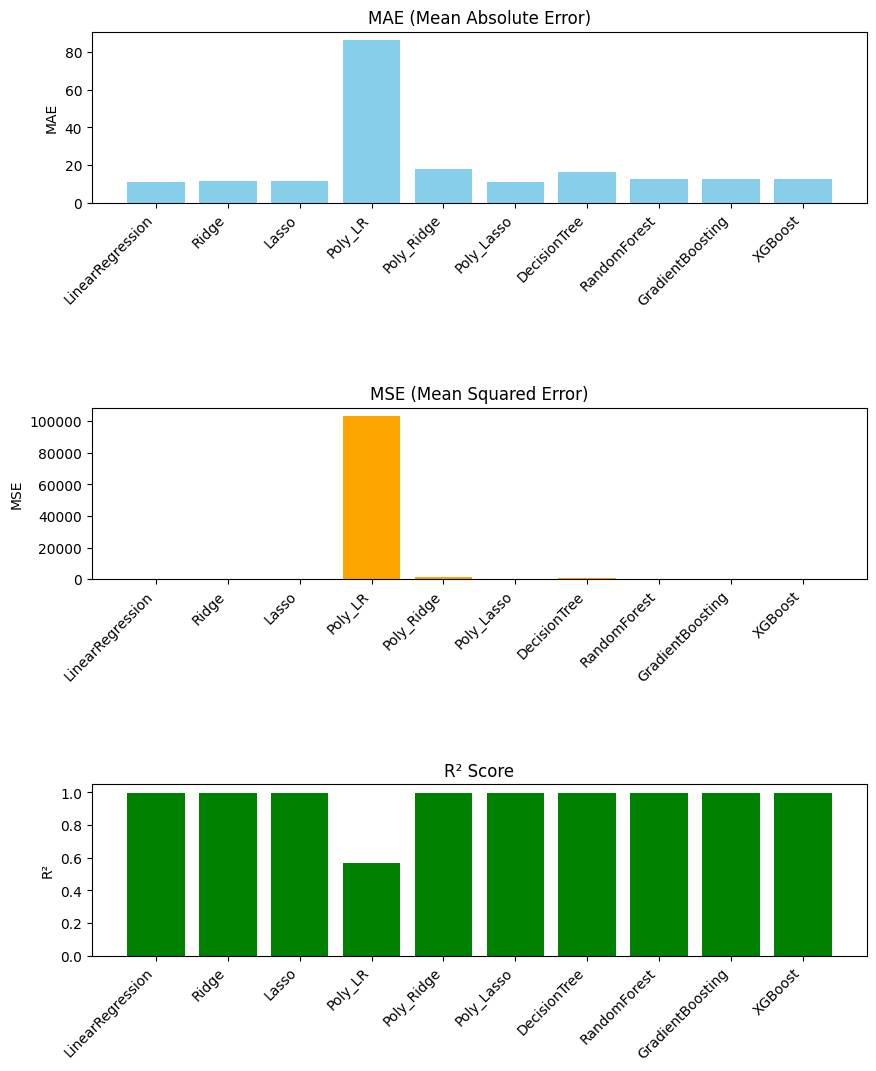

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
plt.subplots_adjust(hspace=1.2)

# Histogram MAE
axes[0].bar(results_df["model"], results_df["mae"], color="skyblue")
axes[0].set_title("MAE (Mean Absolute Error)")
axes[0].set_ylabel("MAE")
axes[0].set_xticklabels(results_df["model"], rotation=45, ha="right")

# Histogram MSE
axes[1].bar(results_df["model"], results_df["mse"], color="orange")
axes[1].set_title("MSE (Mean Squared Error)")
axes[1].set_ylabel("MSE")
axes[1].set_xticklabels(results_df["model"], rotation=45, ha="right")

# Histogram R²
axes[2].bar(results_df["model"], results_df["r2"], color="green")
axes[2].set_title("R² Score")
axes[2].set_ylabel("R²")
axes[2].set_xticklabels(results_df["model"], rotation=45, ha="right")

plt.show()

#### Conclusion

- Under **time-series (chronological) validation**, models that looked reasonable in-sample performed **very poorly out-of-sample**, with reported **R² values ranging approximately from -0.525 to -0.479**. This indicates extreme overfitting to historical patterns and/or strong non-stationarity in the gold price series.
- By contrast, when the data were **randomly shuffled** and split, models reached **very high R² (≈0.998–0.999)** and low MAE (~11–12). This demonstrates that the models are learning short-term correlations rather than true forward-predictive structure.

- **Temporal instability:** The gold price series exhibits strong regime changes, making standard ML regressors unreliable for true forecasting.  
- **Feature leakage avoidance:** Time-based validation confirmed that lag features must be handled carefully to avoid future data leakage.  
- **Interpretability focus:** Even though temporal prediction failed, the random-split experiments were valuable for understanding **feature relevance** and **model behavior**.  
- **Regularization impact:** Ridge and Lasso maintained similar patterns to tree-based models, implying most signal was linear and short-term.

#### Key Lessons

1. **High R² doesn’t mean predictability:** Random-split evaluation creates an illusion of performance; real-world generalization requires time-aware validation.  
2. **Financial time series ≠ stationary signals:** Relationships between features and target evolve; no static model can capture long-term structure without adaptation.  
3. **Useful outcome:** Even without accurate forecasts, the experiment yielded strong insights into feature dynamics and model sensitivity.  
4. **Future work:** Consider models that explicitly handle non-stationarity (e.g., recurrent neural networks, transformers, or dynamic regressors) and re-train adaptively.